In [1]:
# Edgar new data Jan 2024

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import pathlib
from pathlib import Path

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from models import *
from utils import *

from loguru import logger
from sklearn.linear_model import TweedieRegressor
from preprocessing import *

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

NVIDIA GeForce GTX TITAN X


### Load Data

In [2]:
'''
The imaging is still at 30hz.
The ephys is binarized in 1ms bins.
The speed has corresponding triggers in imaging and ephys.
I.e. for every entry in the speed file, there is a corresponding imaging frame or ephys bin at the given index.
There are files for baseline and for stimulation. In each case, the imaging ROIs and the ephys units are matched.
I.e. index 1 in baseline imaging is the same cell as index 1 is stim imaging.

Please see if this format works for you. Let me know if you want me to downsample all of them to the same frame rate (30Hz) instead if that is easier for you. If this runs ok, then I can run another 1-2 mice through which should put us at 3-4 animals. I will work on getting the combinatorial paradigm in place as well, but it is a little bit complicated right now.
'''
parent_path = Path('./data/biological/EB095/')
stim_path = parent_path / "EB095_stim/"
run_path = parent_path / "EB095_run/"
save_path = Path('./save/trained_models/EB095/')

area_ID_ephys = np.load(run_path / 'area_ID_ephys.npy')        # (106,) 8 LS, 70 ACC
dff_run = np.load(run_path / 'dff_run.npy')                    # (294, 32727) GCaMP when running
dff_stim = np.load(stim_path /'dff_stim.npy')                  # (294, 94696) GCaMP when stimulated 
spks_run = np.load(run_path / 'spks_run.npy')                  # (106, 32727)
spks_stim = np.load(stim_path /'spks_stim.npy')                # (106, 94096)
speed_run = np.load(run_path / 'speed_run.npy')                # (32727,) max 13

# speed_triggers_ephys_run = np.load(run_path / 'speed_triggers_ephys_run.npy')  # (56322)
# speed_triggers_img_run = np.load(run_path / 'speed_triggers_img_run.npy')      # (56322)
stim_ID = np.load(stim_path /'stim_ID.npy')
stim_ID_resolved = np.load(stim_path /'stim_ID_resolved.npy')  # (300, 6), R S or F
stim_time = np.load(stim_path /'stim_triggers.npy')            # (300, )

Exploratory analysis: Running vs Activity

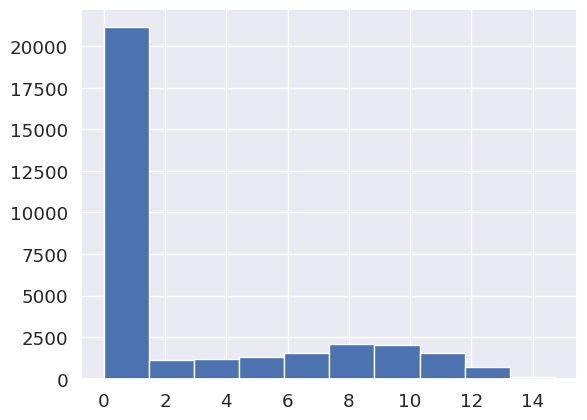

In [3]:
# (106, 56322)
plt.hist(speed_run) # (56302)
plt.show()

Naive model fitting:
Ignore running / stationary, fit model to both data.

### Preprocessing

#### Convolve spikes

2024-03-18 15:21:00.191 | INFO     | preprocessing:convolve_spikes:26 - Detected Ephys file with 106 neurons and 94696 bins.
2024-03-18 15:21:00.647 | INFO     | preprocessing:convolve_spikes:51 - Produced convolved rates at sigma=0.1 with 106 neurons and 94696 bins.


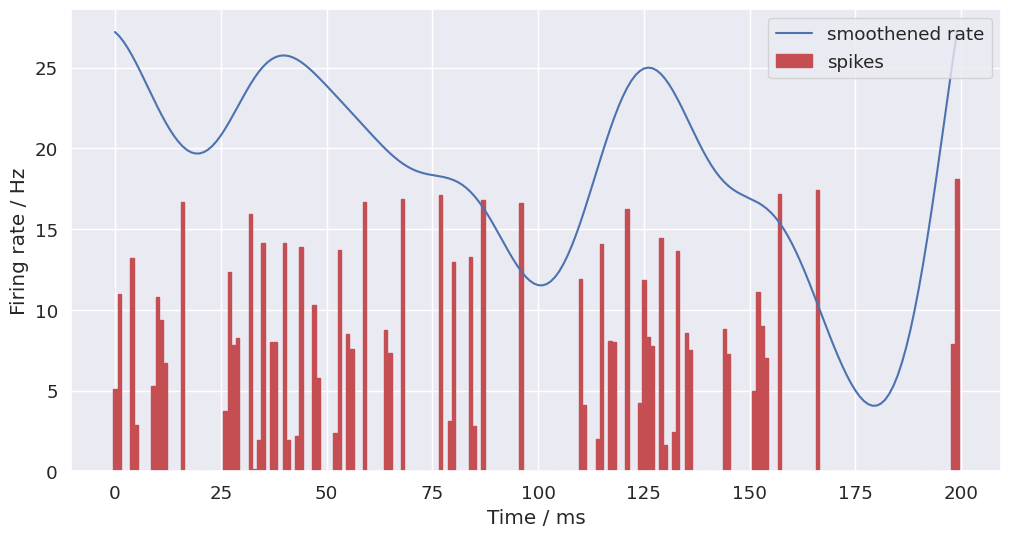

In [4]:
spks_stim_rates, n_output_neurons, n_bins = convolve_spikes(spks_stim)
plot_convolution_example(spks_stim_rates, spks_stim,seed=seed)
input_dim = dff_stim.shape[0]
assert n_bins == dff_stim.shape[1]

##### Average firing rates of each neuron

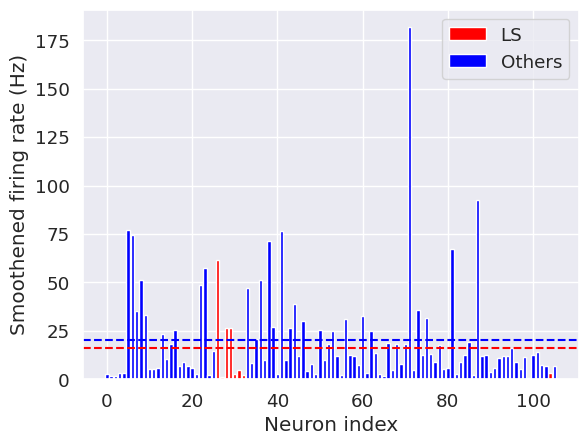

LS neuron firing rate: 16.095746994018555 Hz
non-LS neuron firing rate: 20.01192283630371 Hz


In [5]:
mask1 = area_ID_ephys == 'LS'
mask2 = area_ID_ephys != 'LS'

plt.bar(np.arange(spks_stim_rates.shape[1])[mask1], spks_stim_rates.mean(0)[mask1], color='red', label='LS')
plt.bar(np.arange(spks_stim_rates.shape[1])[mask2], spks_stim_rates.mean(0)[mask2], color='blue', label='Others')
plt.axhline(spks_stim_rates.mean(0)[mask1].mean(), linestyle='--', color='red')
plt.axhline(spks_stim_rates.mean(0)[mask2].mean(), linestyle='--', color='blue')
plt.legend()
plt.xlabel('Neuron index')
plt.ylabel('Smoothened firing rate (Hz)')
plt.show()
print(f'LS neuron firing rate: {spks_stim_rates.mean(0)[mask1].mean()} Hz')
print(f'non-LS neuron firing rate: {spks_stim_rates.mean(0)[mask2].mean()} Hz')

#### Extact stim instances

In [6]:
inputs, targets, non_stim_vecs_idx, stim_vecs_idx = preprocess_dff_rate_pairs(dff_stim, spks_stim_rates, has_stim=True, stim_time=stim_time, stim_ID=stim_ID, cutoff_size=1, offset=-3, tsteps=15)
sampled_non_stim_vecs = sample_non_stim_vecs(non_stim_vecs_idx, cutoff_size=1, n=200, seed=seed)
test_set_idx = np.concatenate([stim_vecs_idx, sampled_non_stim_vecs])
X_train, Y_train = inputs[non_stim_vecs_idx], targets[non_stim_vecs_idx]
X_test, Y_test = inputs[test_set_idx], targets[test_set_idx]

We sample 200 endogenous activity vectors, delete 4 vectors (4 * 15 * 33 = 2 secs) steps before and after.

## Training

### LS Neurons

In [7]:
LS_neuron_idx = np.where(area_ID_ephys == 'LS')[0]
ACC_neuron_idx = np.where(area_ID_ephys == 'ACC')[0]
Others_neuron_idx = np.where(area_ID_ephys == 'Other')[0]
nLS_neuron_idx = np.where(area_ID_ephys != 'LS')[0]

# randomise valid idx
n_non_stim = len(Y_train)
valid_idx = np.random.choice(np.arange(len(Y_train)), int(n_non_stim * 0.10))
train_idx = np.array(list((set(np.arange(len(Y_train))) - set(valid_idx))))


forward_mse_idx = list(np.nonzero(np.array(stim_ID) == 'F')[0])
backward_mse_idx = list(np.nonzero(np.array(stim_ID) == 'R')[0])
random_mse_idx = list(np.nonzero(np.array(stim_ID) == 'S')[0])
non_stim_mse_idx = np.arange(len(stim_ID), Y_test.shape[0])

In [8]:
# 8 neurons are lateral septal according to Edgar
Y_train_LS = Y_train[train_idx,:,:][..., LS_neuron_idx]
Y_test_LS = Y_test[..., LS_neuron_idx]
Y_valid_LS = Y_train[valid_idx,:,:][..., LS_neuron_idx]

output_dim = len(LS_neuron_idx)

batch_size = 1024
train_dataset = BNN_Dataset(X_train[train_idx, ...], Y_train_LS)
train_dataloader_LS = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
test_dataset = BNN_Dataset(X_test, Y_test_LS)
test_dataloader_LS = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=False, shuffle=False)
valid_dataset = BNN_Dataset(X_train[valid_idx, ...], Y_valid_LS)
valid_dataloader_LS = DataLoader(valid_dataset, batch_size=len(valid_dataset), drop_last=False, shuffle=False)
del train_dataset, test_dataset, valid_dataset

# fit GLM with identity link function
X_train_np = X_train[train_idx, ...].cpu().numpy().reshape(X_train[train_idx, ...].shape[0],-1)
Y_train_LS_np = Y_train_LS.cpu().numpy().reshape(Y_train_LS.shape[0],-1) + 1e-6 # numerical stability

X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
Y_test_LS_np = Y_test_LS.cpu().numpy().reshape(Y_test_LS.shape[0],-1) + 1e-6 # numerical stability

#### Bayes Opt

In [10]:
_run = True
from bayes_opt import BayesianOptimization
from models import TransformerOneStep
from train import train_transformer, eval_transformer
from utils import count_parameters

LS_param_counts = []

import gc
def black_box_function(d_model, num_heads, hidden_dim, n_layers, seed=seed):
    gc.collect()
    torch.cuda.empty_cache()
    
    seed = 123
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    hidden_dim, d_model, n_layers, num_heads = int(hidden_dim), int(d_model), int(n_layers), int(num_heads)
    d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
    if d_model %2 != 0:
        d_model += num_heads
        
    DNN = TransformerOneStep(input_dim,
                d_model=d_model,
                num_heads=num_heads,
                hidden_dim=hidden_dim,
                output_dim=output_dim,
                n_encoder_layers=n_layers,
                device=device, 
                max_len=30,
                dropout=0.2,
                use_mask=False,
                pos_output=True,
                bin_output=False,
                softmax_output=False).to(device)
    
    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=10, threshold=0.01)

    return_dict = train_transformer(
        model=DNN,
        train_loader=train_dataloader_LS, test_loader=valid_dataloader_LS, # use valid loader here
        optimiser=optimiser, criterion=criterion, num_epochs=250,
        verbose=False, force_stop=False, scheduler=scheduler)

    LS_param_counts.append([min(return_dict['eval_losses']), count_parameters(DNN), d_model, num_heads, hidden_dim, n_layers])
    valid_loss = -min(return_dict['eval_losses'])   
    del DNN, return_dict
    gc.collect()
    torch.cuda.empty_cache()
    return valid_loss

def run_bayes_opt(pbounds, init_points=100, n_iter=100):
    optimizer = BayesianOptimization(f=black_box_function, pbounds=pbounds, random_state=123)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

if _run:
    run_bayes_opt(pbounds = {'d_model':(100, 2000), 'num_heads':(1, 30), 'hidden_dim':(100, 1000), 'n_layers':(1, 5)}, init_points=200, n_iter=200)
    np.save(f'./data/trained_models/EB095-stim-LS-param_counts.npy', np.array(LS_param_counts))

|   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
-------------------------------------------------------------------------


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 44%|████▎     | 109/250 [02:57<03:49,  1.63s/it]


| 1         | nan       | 1.423e+03 | 357.5     | 1.907     | 16.99     |


  0%|          | 0/250 [00:04<?, ?it/s]


KeyboardInterrupt: 

#### Train Transformer

In [9]:
# TRANSFORMER
# |   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
# | 55        | -113.2    | 445.1     | 389.2     | 4.382     | 6.42      |
# | 36        | -123.9    | 277.3     | 367.2     | 4.71      | 17.5      |
# | 55        | -113.2    | 455.1     | 389.2     | 4.382     | 6.42      | 

d_model = 304
num_heads = 19
hidden_dim = 948
n_layers = 4

d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
if d_model % 2 != 0:
    d_model += num_heads

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from models import TransformerOneStep

DNN_LS = TransformerOneStep(input_dim,
                d_model=d_model,
                num_heads=num_heads,
                hidden_dim=hidden_dim,
                output_dim=output_dim,
                n_encoder_layers=n_layers,
                device=device, 
                max_len=30,
                dropout=0.2,
                decoder='linear',
                decoder_hidden_dim=None,
                use_mask=True,
                pos_output=True,
                bin_output=False,
                softmax_output=False).to(device)


assert len(np.intersect1d(forward_mse_idx, backward_mse_idx)) == 0
assert len(np.intersect1d(backward_mse_idx, random_mse_idx)) == 0
assert len(np.intersect1d(random_mse_idx, non_stim_mse_idx)) == 0
assert len(np.intersect1d(non_stim_mse_idx, forward_mse_idx)) == 0

/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [18]:
import wandb
wandb.login()
wandb.init(project='approx_brain')

return_dict = None # intialise as None
n_cycles = 1
for _ in range(n_cycles):
    optimiser = torch.optim.Adam(DNN_LS.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.MSELoss(reduction='none')
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 
                                                        mode='min', 
                                                        factor=0.5, 
                                                        patience=10, 
                                                        threshold=0.01)
    num_epochs = 500

    from train import train_transformer, eval_transformer

    return_dict = train_transformer(
                model=DNN_LS,
                train_loader=train_dataloader_LS,
                test_loader=test_dataloader_LS,
                optimiser=optimiser,
                criterion=criterion,
                num_epochs=num_epochs,
                verbose=True,
                batch_first=True,
                scheduler=scheduler,
                use_wandb=False,
                stim_type_indices=
                [forward_mse_idx, backward_mse_idx, random_mse_idx, non_stim_mse_idx],
                prev_return_dict=return_dict)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


backward_loss,█▅▄▁▂▂▁▁▁▁▂▁▁▂▂▁▂▂▃▂▃▂▂▂▂▃▃▂▃▂▂▃▃▃▂▃▂▂▂▃
eval_loss,█▅▃▃▂▂▁▁▁▁▁▁▁▁▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
forward_loss,█▆▄▃▂▂▂▂▂▁▂▂▁▂▂▂▃▃▄▃▃▃▃▂▃▃▃▃▃▃▃▃▃▄▃▃▃▃▃▃
learning_rate,████████████████████▄▄▄▄▄▄▄▄▂▂▂▂▂▂▂▂▁▁▁▁
nonstim_loss,█▄▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
random_loss,█▅▄▃▃▃▁▁▁▁▂▁▁▁▃▂▂▃▃▃▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
train_loss,█▆▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
backward_loss,40.5136
eval_loss,57.59321
forward_loss,55.33669
learning_rate,0.00013


Initial eval loss: 1104.4252262180762


  0%|          | 1/500 [00:00<07:10,  1.16it/s]

Epoch 1: training loss 894.474609375, eval loss 871.1933116130581. Time elapsed: 0 h 0 m 1 s.


  5%|▌         | 26/500 [00:22<06:41,  1.18it/s]

Epoch 26: training loss 213.5089904785156, eval loss 261.65964147804937. Time elapsed: 0 h 0 m 22 s.


 10%|█         | 51/500 [00:43<06:20,  1.18it/s]

Epoch 51: training loss 89.54095764160157, eval loss 162.8185152435213. Time elapsed: 0 h 0 m 43 s.


 15%|█▌        | 76/500 [01:04<05:58,  1.18it/s]

Epoch 76: training loss 45.61943893432617, eval loss 153.64305558491705. Time elapsed: 0 h 1 m 4 s.


 20%|██        | 101/500 [01:25<05:38,  1.18it/s]

Epoch 101: training loss 25.570075607299806, eval loss 144.60812732522135. Time elapsed: 0 h 1 m 26 s.


 25%|██▌       | 126/500 [01:47<05:16,  1.18it/s]

Epoch 126: training loss 20.26324119567871, eval loss 145.4649849360421. Time elapsed: 0 h 1 m 47 s.


 30%|███       | 151/500 [02:08<04:56,  1.18it/s]

Epoch 151: training loss 19.299411392211915, eval loss 147.02458699404698. Time elapsed: 0 h 2 m 8 s.


 35%|███▌      | 176/500 [02:29<04:34,  1.18it/s]

Epoch 176: training loss 19.21805534362793, eval loss 146.7166055779804. Time elapsed: 0 h 2 m 30 s.


 38%|███▊      | 191/500 [02:43<04:24,  1.17it/s]


In [ ]:
# optional: save trained model
import datetime
import os
import pickle

timestamp = '-'.join(str(datetime.datetime.now()).split(' '))

data = {'metadata':{'timestamp': timestamp,
                    'save_path': f'./data/biological/trained_models/'},
        'params':{'seed':seed,
                    'sigma': 0.1,
                    'batch_size': batch_size,
                    'tsteps': 15,
                    'input_dim': input_dim,
                    'd_model': d_model,
                    'num_heads': num_heads,
                    'hidden_dim': hidden_dim,
                    'output_dim': output_dim,
                    'n_layers': n_layers,
                    'num_epochs': num_epochs}
        }

torch.save(return_dict['best_eval_params'], save_path / f'EB095-stim-LS-transformer-param-{d_model}-{num_heads}-{hidden_dim}-{n_layers}-mk3.pth')
with open(save_path / f'EB095-stim-LS-transformer-param-metadata-{d_model}-{num_heads}-{hidden_dim}-{n_layers}-mk3.pkl', 'wb') as f:
    pickle.dump(data, f)
print(f'Saved model parameters and training stats to ./save/trained_models/EB095-stim-LS-transformer-param-metadata-{d_model}-{num_heads}-{hidden_dim}-{n_layers}-mk3')

Saved model parameters and training stats to ./save/trained_models/EB095-stim-LS-transformer-param-metadata-444-6-389-4-mk3


In [10]:
with open(save_path / f'EB095-stim-LS-transformer-param-metadata-304-19-948-4-trained-30.pkl', 'rb') as f:
    data = pickle.load(f)
best_eval_params = torch.load(save_path /f'EB095-stim-LS-transformer-param-304-19-948-4-trained-30.pth')
DNN_LS.load_state_dict(best_eval_params)

with torch.no_grad():
    Y_hat_LS = DNN_LS(X_test.to(device).permute(1,0,2)).permute(1,0,2).cpu()
    LS_test_pred_loss = nn.MSELoss(reduction='none')(Y_hat_LS, Y_test[...,LS_neuron_idx])
    print('Overall Transformer Loss:', LS_test_pred_loss.sum()/np.prod(LS_test_pred_loss.shape))
    print('Transformer prediction for forward stim MSE loss: ', LS_test_pred_loss[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim)
    print('Transformer prediction for backward stim MSE loss: ', LS_test_pred_loss[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim)
    print('Transformer prediction for random stim MSE loss: ', LS_test_pred_loss[random_mse_idx].sum() / len(random_mse_idx)/output_dim)
    print('Transformer prediction for non-stim stim MSE loss: ', LS_test_pred_loss[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim)

Overall Transformer Loss: tensor(126.2583)
Transformer prediction for forward stim MSE loss:  tensor(140.8299)
Transformer prediction for backward stim MSE loss:  tensor(136.9874)
Transformer prediction for random stim MSE loss:  tensor(121.6547)
Transformer prediction for non-stim stim MSE loss:  tensor(115.8331)


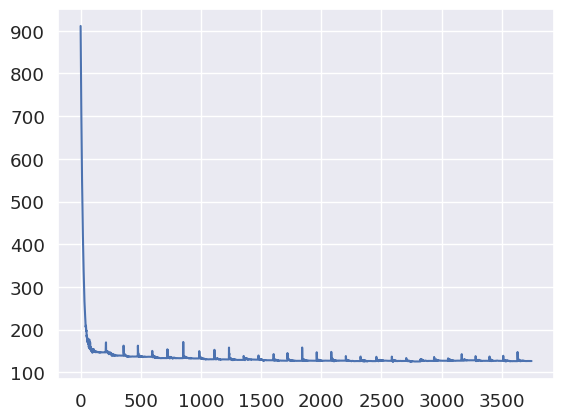

In [11]:
plt.plot(data['return_dict']['eval_losses'])

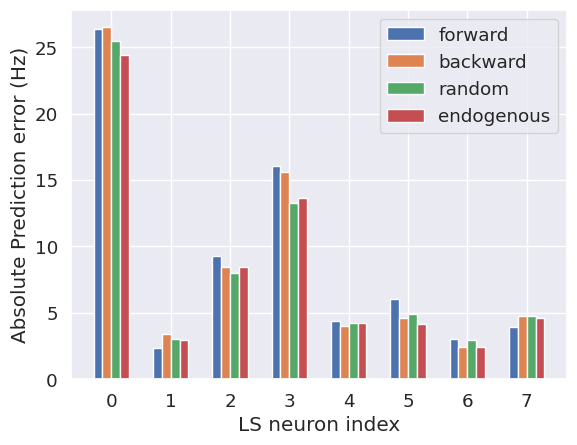

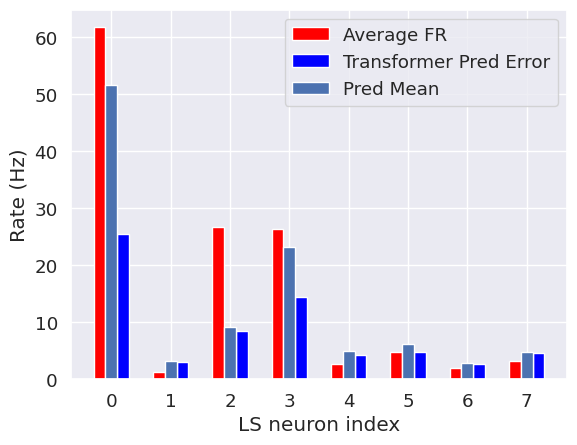

In [24]:
plt.figure()
plt.bar(np.arange(len(LS_neuron_idx)) - 0.225, torch.sqrt(LS_test_pred_loss[forward_mse_idx, 0].sum(0)/len(forward_mse_idx)), width=0.15, label='forward')
plt.bar(np.arange(len(LS_neuron_idx)) - 0.075, torch.sqrt(LS_test_pred_loss[backward_mse_idx, 0].sum(0)/len(backward_mse_idx)), width=0.15, label='backward')
plt.bar(np.arange(len(LS_neuron_idx)) + 0.075, torch.sqrt(LS_test_pred_loss[random_mse_idx, 0].sum(0)/len(random_mse_idx)), width=0.15, label='random')
plt.bar(np.arange(len(LS_neuron_idx)) + 0.225, torch.sqrt(LS_test_pred_loss[non_stim_mse_idx, 0].sum(0)/len(non_stim_mse_idx)), width=0.15, label='endogenous')

plt.xlabel('LS neuron index')
plt.ylabel('Absolute Prediction error (Hz)')
plt.legend()
plt.show()

plt.figure()
plt.bar(np.arange(len(LS_neuron_idx)) - 0.2, spks_stim_rates.mean(0)[mask1], color='red', width=0.2, label='Average FR')
plt.bar(np.arange(len(LS_neuron_idx)) + 0.2, torch.sqrt(LS_test_pred_loss.sum(0)[0]/LS_test_pred_loss.shape[0]), color='blue', width=0.2, label='Transformer Pred Error')
try:
    Y_test_LS_np
    plt.bar(np.arange(len(LS_neuron_idx)), np.sqrt(np.power(Y_test_LS_np - Y_test_LS_np.mean(0), 2).sum(0) / Y_test_LS_np.shape[0]), width=0.2, label='Pred Mean')
except: pass

plt.xlabel('LS neuron index')
plt.ylabel('Rate (Hz)')
plt.legend()
plt.show()

#### Train GLM

In [21]:
# pred for each neuron
glm_LS_losses = np.zeros_like(Y_test_LS_np) # (500, 8)
output_dim = Y_test_LS_np.shape[1]

for i in range(output_dim):
    glm_LS_reg = TweedieRegressor(power=0, alpha=1, link='auto')
    glm_LS_reg.fit(X_train_np, Y_train_LS_np[:,i])
    
    glm_LS_losses[:,i] += np.power(Y_test_LS_np[:,i] - glm_LS_reg.predict(X_test_np), 2)
    logger.info(f'Loss for LS neuron No {i}: {glm_LS_losses[:,i].sum() / Y_test_LS_np.shape[0]} (Hz^2).')
    logger.info(f'Forward: {glm_LS_losses[forward_mse_idx,i].sum() / len(forward_mse_idx)}, Backward: {glm_LS_losses[backward_mse_idx,i].sum() / len(backward_mse_idx)}, Random: {glm_LS_losses[random_mse_idx, i].sum() / len(random_mse_idx)}. Endogenous: {glm_LS_losses[non_stim_mse_idx, i].sum() / len(non_stim_mse_idx)}')

logger.info(f'Pred mean overall loss: {np.power(Y_test_LS_np - Y_test_LS_np.mean(0), 2).sum() / np.prod(Y_test_LS_np.shape)}')
logger.info(f'GLM with identity function overall loss: {glm_LS_losses.sum() / np.prod(Y_test_LS.shape)}')

logger.info(f'GLM prediction for forward stim R2 loss: {glm_LS_losses[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim}')
logger.info(f'GLM prediction for backward stim R2 loss: {glm_LS_losses[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim}')
logger.info(f'GLM prediction for random stim R2 loss: {glm_LS_losses[random_mse_idx].sum() / len(random_mse_idx)/output_dim}')
logger.info(f'GLM prediction for non-stim stim R2 loss: {glm_LS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim}')

np.save(save_path / 'EB095-stim-LS-glm-losses.npy', glm_LS_losses)

2024-03-06 20:06:24.185 | INFO     | __main__:<module>:10 - Loss for LS neuron No 0: 982.76675 (Hz^2).
2024-03-06 20:06:24.186 | INFO     | __main__:<module>:11 - Forward: 922.4640625, Backward: 1016.2884436881188, Random: 955.030303030303. Endogenous: 1009.7190625
2024-03-06 20:06:29.454 | INFO     | __main__:<module>:10 - Loss for LS neuron No 1: 9.38494921875 (Hz^2).
2024-03-06 20:06:29.455 | INFO     | __main__:<module>:11 - Forward: 4.498933715820312, Backward: 12.096077796256187, Random: 12.459224816524621. Endogenous: 8.93707275390625
2024-03-06 20:06:35.549 | INFO     | __main__:<module>:10 - Loss for LS neuron No 2: 72.6524375 (Hz^2).
2024-03-06 20:06:35.550 | INFO     | __main__:<module>:11 - Forward: 77.4237353515625, Backward: 71.72193107982673, Random: 63.01589133522727. Endogenous: 75.5067822265625
2024-03-06 20:06:43.299 | INFO     | __main__:<module>:10 - Loss for LS neuron No 3: 298.715 (Hz^2).
2024-03-06 20:06:43.299 | INFO     | __main__:<module>:11 - Forward: 309.49

2024-03-18 11:59:48.388 | INFO     | __main__:<module>:2 - Predicting mean for each of the 8 LS neurons: [2660.0437      10.088681    83.17797    537.7365      25.38467
   37.314613     7.9869194   23.41918  ]


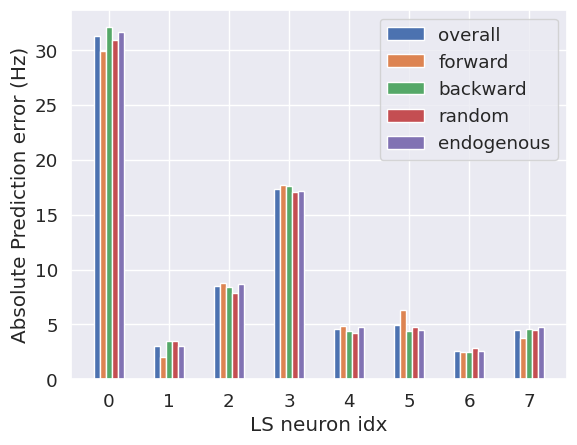

In [25]:
glm_LS_losses = np.load(save_path / 'EB095-stim-LS-glm-losses.npy')
logger.info(f'Predicting mean for each of the 8 LS neurons: {np.power(Y_test_LS_np - Y_test_LS_np.mean(0), 2).sum(0) / Y_test_LS_np.shape[0]}')

plt.figure()
plt.bar(np.arange(8)-0.2, np.sqrt(glm_LS_losses.mean(0)), width=0.1, label='overall')
plt.bar(np.arange(8)-0.1, np.sqrt(glm_LS_losses[forward_mse_idx].mean(0)), width=0.1, label='forward')
plt.bar(np.arange(8), np.sqrt(glm_LS_losses[backward_mse_idx].mean(0)), width=0.1, label='backward')
plt.bar(np.arange(8)+0.1, np.sqrt(glm_LS_losses[random_mse_idx].mean(0)), width=0.1, label='random')
plt.bar(np.arange(8)+0.2, np.sqrt(glm_LS_losses[non_stim_mse_idx].mean(0)), width=0.1, label='endogenous')
plt.xlabel('LS neuron idx')
plt.ylabel('Absolute Prediction error (Hz)')
plt.legend()
plt.show()

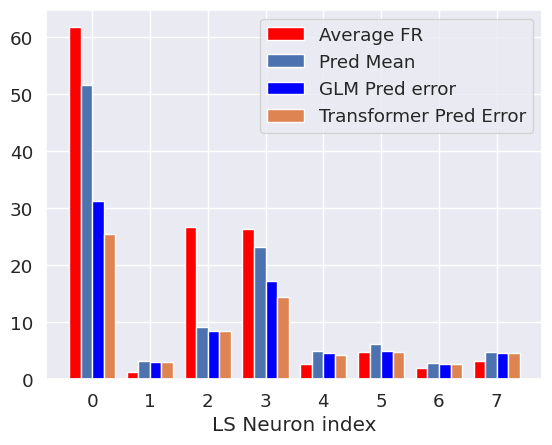

In [26]:
plt.figure()
plt.bar(np.arange(8) - 0.3, spks_stim_rates.mean(0)[mask1], color='red', width=0.2, label='Average FR')
plt.bar(np.arange(len(LS_neuron_idx)) - 0.1, np.sqrt(np.power(Y_test_LS_np - Y_test_LS_np.mean(0), 2).sum(0) / Y_test_LS_np.shape[0]), width=0.2, label='Pred Mean')
plt.bar(np.arange(8) + 0.1, np.sqrt(glm_LS_losses.sum(0)/glm_LS_losses.shape[0]), color='blue', width=0.2, label='GLM Pred error')
plt.bar(np.arange(len(LS_neuron_idx)) + 0.3, torch.sqrt(LS_test_pred_loss.sum(0)[0]/LS_test_pred_loss.shape[0]), width=0.2, label='Transformer Pred Error')
plt.legend()
plt.xlabel('LS Neuron index')
plt.show()

#### Train RNN

In [ ]:
run_bayes_opt = False
from bayes_opt import BayesianOptimization
from models import RecurrentDNN
from train import train_rnn
from utils import count_parameters

LS_rnn_param_counts = []

import gc
def black_box_function(hidden_dim, n_rec_layers, n_input_layers, n_output_layers, seed=seed):
    gc.collect()
    torch.cuda.empty_cache()
    
    seed = 123
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    hidden_dim = int(hidden_dim)
    n_rec_layers = int(n_rec_layers)
    
    rnn = RecurrentDNN(input_dim=input_dim,
                hidden_dim=hidden_dim,
                n_rec_layers=n_rec_layers, 
                output_dim=output_dim, 
                n_input_layers=1,
                n_output_layers=1,
                bidirectional=False,
                _type='lstm',
                pos_output=True,
                output_step=1,
                batch_first=True).to(device)
    
    optimiser = torch.optim.Adam(rnn.parameters(), lr=1e-3, weight_decay=1e-3)
    criterion = nn.MSELoss()
    
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=10, threshold=0.01)

    return_dict = train_rnn(
        model=rnn, 
        train_loader=train_dataloader_LS, 
        test_loader=test_dataloader_LS, 
        optimiser = optimiser, 
        criterion = criterion, 
        num_epochs = 500, 
        verbose=False, 
        force_stop=False, 
        scheduler=scheduler)

    LS_rnn_param_counts.append([min(return_dict['eval_losses']), count_parameters(rnn), n_rec_layers, hidden_dim])
    valid_loss = -min(return_dict['eval_losses'])   
    del rnn, return_dict
    gc.collect()
    torch.cuda.empty_cache()
    return valid_loss

def run_bayes_opt(pbounds, init_points=50, n_iter=50):
    optimizer = BayesianOptimization(f=black_box_function, pbounds=pbounds, random_state=1)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

if run_bayes_opt:
    run_bayes_opt(pbounds = {'hidden_dim':(10, 1200), 'n_rec_layers':(1, 3), 'n_input_layers':(0, 3), 'n_output_layers':(0, 3)}, init_points=50, n_iter=50)
    np.save(f'./data/trained_models/EB095-stim-LS-rnn-param_counts.npy', np.array(LS_rnn_param_counts))

|   iter    |  target   | hidden... | n_inpu... | n_outp... | n_rec_... |
-------------------------------------------------------------------------


  9%|▊         | 43/500 [00:11<02:05,  3.63it/s]


KeyboardInterrupt: 

In [28]:
# |   iter    |  target   | hidden... | n_inpu... | n_outp... | n_rec_... |
# | 9         | -149.1    | 1.916e+03 | 2.133     | 2.768     | 1.947     |
# | 82        | -149.4    | 1.16e+03  | 2.855     | 0.006638  | 2.496     |
n_input_layers = 2
hidden_dim = 1916
n_output_layers = 2
n_rec_layers = 1

import copy
from train import train_rnn, eval_rnn
from models import RecurrentDNN


rnn = RecurrentDNN(input_dim=input_dim,
                hidden_dim=hidden_dim,
                n_rec_layers=n_rec_layers, 
                output_dim=output_dim, 
                n_input_layers=n_input_layers,
                n_output_layers=n_output_layers,
                bidirectional=False,
                _type='lstm',
                pos_output=True,
                output_step=1,
                batch_first=True).to(device)

In [25]:
optimiser = torch.optim.Adam(rnn.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.MSELoss()

# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=10, threshold=0.01)

return_dict = train_rnn(
    model=rnn, 
    train_loader=train_dataloader_LS, 
    test_loader=test_dataloader_LS, 
    optimiser = optimiser, 
    criterion = criterion, 
    num_epochs = 500, 
    verbose=True, 
    force_stop=False, 
    scheduler=scheduler)

with torch.no_grad():
    _, Y_hat_LS_rnn = eval_rnn(rnn, test_dataloader_LS, nn.MSELoss(), True)
    LS_rnn_loss = np.power(Y_test_LS[:,0,:][:,None,:] - Y_hat_LS_rnn.cpu(), 2)

torch.save(return_dict['best_eval_params'], save_path / f'EB095-stim-LS-RNN-param-{n_input_layers}-{hidden_dim}-{n_output_layers}-{n_rec_layers}')
np.save(save_path / f'EB095-stim-LS-RNN-param-{n_input_layers}-{hidden_dim}-{n_output_layers}-{n_rec_layers}-loss.npy', LS_rnn_loss.cpu().numpy())

Initial eval loss: 1113.4093017578125


  0%|          | 1/500 [00:03<33:15,  4.00s/it]

Epoch 1: training loss 698.1200256347656, eval loss 476.154052734375. Time elapsed: 0 h 0 m 4 s.


  5%|▌         | 26/500 [01:41<31:05,  3.94s/it]

Epoch 26: training loss 50.59625244140625, eval loss 165.11647033691406. Time elapsed: 0 h 1 m 41 s.


 10%|█         | 51/500 [03:20<29:33,  3.95s/it]

Epoch 51: training loss 22.07135925292969, eval loss 167.92333984375. Time elapsed: 0 h 3 m 20 s.


 15%|█▌        | 76/500 [04:59<28:10,  3.99s/it]

Epoch 76: training loss 17.706948852539064, eval loss 168.57382202148438. Time elapsed: 0 h 4 m 59 s.


 20%|██        | 101/500 [06:39<26:23,  3.97s/it]

Epoch 101: training loss 16.94501190185547, eval loss 168.90469360351562. Time elapsed: 0 h 6 m 39 s.


 21%|██▏       | 107/500 [07:03<26:17,  4.01s/it]

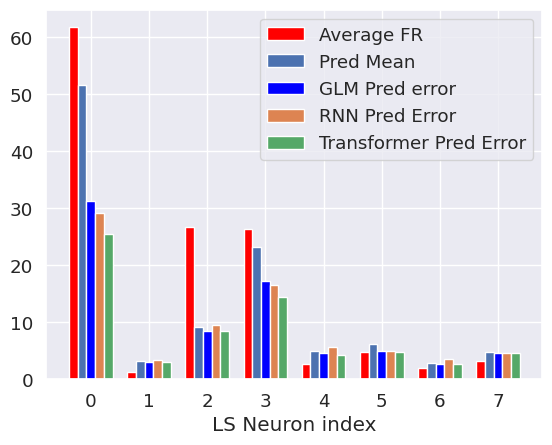

In [29]:
LS_rnn_loss = torch.as_tensor(np.load(save_path / f'EB095-stim-LS-RNN-param-{n_input_layers}-{hidden_dim}-{n_output_layers}-{n_rec_layers}-loss.npy'))
plt.figure()
plt.bar(np.arange(8) - 0.3, spks_stim_rates.mean(0)[mask1], color='red', width=0.15, label='Average FR')
plt.bar(np.arange(len(LS_neuron_idx)) - 0.15, np.sqrt(np.power(Y_test_LS_np - Y_test_LS_np.mean(0), 2).sum(0) / Y_test_LS_np.shape[0]), width=0.15, label='Pred Mean')
plt.bar(np.arange(8) + 0, np.sqrt(glm_LS_losses.sum(0)/glm_LS_losses.shape[0]), color='blue', width=0.15, label='GLM Pred error')
plt.bar(np.arange(len(LS_neuron_idx)) + 0.15, torch.sqrt(LS_rnn_loss.mean(0)[0]), width=0.15, label='RNN Pred Error')
plt.bar(np.arange(len(LS_neuron_idx)) + 0.3, torch.sqrt(LS_test_pred_loss.sum(0)[0]/LS_test_pred_loss.shape[0]), width=0.15, label='Transformer Pred Error')

plt.legend()
plt.xlabel('LS Neuron index')
plt.show()

### Non-LS neurons

In [9]:
Y_train_nLS = Y_train[train_idx,:,:][..., nLS_neuron_idx]
Y_test_nLS = Y_test[..., nLS_neuron_idx]
Y_valid_nLS = Y_train[valid_idx,:,:][..., nLS_neuron_idx]

output_dim = len(nLS_neuron_idx)

batch_size = 1024
train_dataset = BNN_Dataset(X_train[train_idx, ...], Y_train_nLS)
train_dataloader_nLS = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
test_dataset = BNN_Dataset(X_test, Y_test_nLS)
test_dataloader_nLS = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=False, shuffle=False)

valid_dataset = BNN_Dataset(X_train[valid_idx, ...], Y_valid_nLS)
valid_dataloader_nLS = DataLoader(valid_dataset, batch_size=len(valid_dataset), drop_last=False, shuffle=False)

#### Bayes Opt

In [33]:
from bayes_opt import BayesianOptimization
from models import TransformerOneStep as TransformerDNN
from train import train_transformer, eval_transformer
import gc

_run = True
nLS_param_counts = []
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def black_box_function(d_model, num_heads, hidden_dim, n_layers, seed=seed):
    gc.collect()
    torch.cuda.empty_cache()
    
    seed = 123
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    hidden_dim, d_model, n_layers, num_heads = int(hidden_dim), int(d_model), int(n_layers), int(num_heads)
    d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
    if d_model %2 != 0:
        d_model += num_heads
        
    DNN = TransformerOneStep(input_dim,
                d_model=d_model,
                num_heads=num_heads,
                hidden_dim=hidden_dim,
                output_dim=output_dim,
                n_encoder_layers=n_layers,
                device=device, 
                max_len=30,
                dropout=0.2,
                use_mask=True,
                pos_output=True,
                bin_output=False,
                softmax_output=False).to(device)
    
    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=10, threshold=0.01)

    return_dict = train_transformer(
        model=DNN,
        train_loader=train_dataloader_nLS, test_loader=valid_dataloader_nLS, # use valid loader here
        optimiser=optimiser, criterion=criterion, num_epochs=250,
        verbose=False, force_stop=False, scheduler=scheduler)
    
    nLS_param_counts.append([min(return_dict['eval_losses']), count_parameters(DNN)])
    valid_loss = -min(return_dict['eval_losses'])   
    del DNN, return_dict
    gc.collect()
    torch.cuda.empty_cache()
    return valid_loss

def run_bayes_opt(pbounds, init_points=100, n_iter=100):
    optimizer = BayesianOptimization(f=black_box_function, pbounds=pbounds, random_state=123)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

if _run:
    run_bayes_opt(pbounds = {'d_model':(100, 2000), 'num_heads':(1, 30), 'hidden_dim':(100, 1000), 'n_layers':(1, 5)}, init_points=200, n_iter=200)

np.save(f'./data/trained_models/EB095-stim-nLS-param_counts.npy', np.array(nLS_param_counts))

|   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
-------------------------------------------------------------------------


OutOfMemoryError: CUDA out of memory. Tried to allocate 130.00 MiB. GPU 0 has a total capacity of 11.91 GiB of which 118.69 MiB is free. Including non-PyTorch memory, this process has 11.74 GiB memory in use. Of the allocated memory 11.43 GiB is allocated by PyTorch, and 176.10 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

#### Train Transformer

In [10]:
# TRANSFORMER
# |   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
# | 6         | -149.4    | 820.7     | 971.4     | 2.254     | 14.15     |

d_model = 820
num_heads = 14
hidden_dim = 971
n_layers = 2

d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
if d_model %2 != 0:
    d_model += num_heads

DNN_nLS = TransformerOneStep(input_dim,
                d_model=d_model,
                num_heads=num_heads,
                hidden_dim=hidden_dim,
                output_dim=output_dim,
                n_encoder_layers=n_layers,
                device=device, 
                max_len=30,
                dropout=0.2,
                use_mask=True,
                pos_output=True,
                bin_output=False,
                softmax_output=False).to(device)

/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [12]:
# import wandb
# wandb.login()
# wandb.init(project='approx_brain')


return_dict = None # intialise as None
n_cycles = 25
for _ in range(n_cycles):
    optimiser = torch.optim.Adam(DNN_nLS.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.MSELoss(reduction='none')
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 
                                                        mode='min', 
                                                        factor=0.5, 
                                                        patience=10, 
                                                        threshold=0.01)
    num_epochs = 500

    from train import train_transformer, eval_transformer

    return_dict = train_transformer(
                model=DNN_nLS,
                train_loader=train_dataloader_nLS,
                test_loader=test_dataloader_nLS,
                optimiser=optimiser,
                criterion=criterion,
                num_epochs=num_epochs,
                verbose=True,
                batch_first=True,
                scheduler=scheduler,
                use_wandb=False,
                stim_type_indices=
                [forward_mse_idx, backward_mse_idx, random_mse_idx, non_stim_mse_idx],
                prev_return_dict=return_dict)

Initial eval loss: 1288.6209723198224


  0%|          | 1/500 [00:01<13:33,  1.63s/it]

Epoch 1: training loss 1195.9630859375, eval loss 1112.6165663469433. Time elapsed: 0 h 0 m 1 s.


  5%|▌         | 26/500 [00:38<11:50,  1.50s/it]

Epoch 26: training loss 269.7292175292969, eval loss 263.02662931262046. Time elapsed: 0 h 0 m 38 s.


 10%|█         | 51/500 [01:19<12:50,  1.72s/it]

Epoch 51: training loss 182.7632629394531, eval loss 187.8441185198248. Time elapsed: 0 h 1 m 19 s.


 15%|█▌        | 76/500 [02:01<11:51,  1.68s/it]

Epoch 76: training loss 151.535595703125, eval loss 172.9807200077325. Time elapsed: 0 h 2 m 1 s.


 20%|██        | 101/500 [02:42<11:07,  1.67s/it]

Epoch 101: training loss 116.05946502685546, eval loss 166.62310422763198. Time elapsed: 0 h 2 m 43 s.


 25%|██▌       | 126/500 [03:25<10:30,  1.69s/it]

Epoch 126: training loss 101.43277587890626, eval loss 167.1519117541908. Time elapsed: 0 h 3 m 25 s.


 30%|███       | 151/500 [04:07<09:48,  1.69s/it]

Epoch 151: training loss 97.90040740966796, eval loss 167.89333580328892. Time elapsed: 0 h 4 m 7 s.


 35%|███▌      | 176/500 [04:50<09:06,  1.69s/it]

Epoch 176: training loss 97.35712280273438, eval loss 167.92306857741764. Time elapsed: 0 h 4 m 50 s.


 40%|███▉      | 199/500 [05:31<08:20,  1.66s/it]


Initial eval loss: 167.88756699605602


  0%|          | 1/500 [00:01<14:04,  1.69s/it]

Epoch 1: training loss 138.1524200439453, eval loss 189.1977524839172. Time elapsed: 0 h 0 m 1 s.


  5%|▌         | 26/500 [00:44<13:22,  1.69s/it]

Epoch 26: training loss 81.09107055664063, eval loss 173.1994546406662. Time elapsed: 0 h 0 m 44 s.


 10%|█         | 51/500 [01:26<12:38,  1.69s/it]

Epoch 51: training loss 74.60327758789063, eval loss 174.90677886039788. Time elapsed: 0 h 1 m 26 s.


 15%|█▌        | 76/500 [02:08<12:11,  1.73s/it]

Epoch 76: training loss 73.287939453125, eval loss 175.19357893929265. Time elapsed: 0 h 2 m 8 s.


 20%|██        | 101/500 [02:51<11:46,  1.77s/it]

Epoch 101: training loss 72.90356903076172, eval loss 175.39313466975952. Time elapsed: 0 h 2 m 51 s.


 22%|██▏       | 111/500 [03:09<11:05,  1.71s/it]


Initial eval loss: 175.36877268213308


  0%|          | 1/500 [00:01<13:58,  1.68s/it]

Epoch 1: training loss 110.72351837158203, eval loss 188.73641225738413. Time elapsed: 0 h 0 m 1 s.


  5%|▌         | 26/500 [00:43<13:20,  1.69s/it]

Epoch 26: training loss 63.467770385742185, eval loss 178.4825308622902. Time elapsed: 0 h 0 m 44 s.


 10%|█         | 51/500 [01:26<12:38,  1.69s/it]

Epoch 51: training loss 57.80249099731445, eval loss 177.5959798174485. Time elapsed: 0 h 1 m 26 s.


 15%|█▌        | 76/500 [02:08<12:06,  1.71s/it]

Epoch 76: training loss 56.64298782348633, eval loss 177.8668849352564. Time elapsed: 0 h 2 m 8 s.


 20%|██        | 101/500 [02:51<11:30,  1.73s/it]

Epoch 101: training loss 56.420677185058594, eval loss 177.8463898218308. Time elapsed: 0 h 2 m 51 s.


 23%|██▎       | 114/500 [03:14<10:59,  1.71s/it]


Initial eval loss: 177.89904796676493


  0%|          | 1/500 [00:01<14:03,  1.69s/it]

Epoch 1: training loss 94.4876922607422, eval loss 185.37929491023874. Time elapsed: 0 h 0 m 1 s.


  5%|▌         | 26/500 [00:44<13:22,  1.69s/it]

Epoch 26: training loss 50.82248764038086, eval loss 177.93773431414462. Time elapsed: 0 h 0 m 44 s.


 10%|█         | 51/500 [01:26<12:34,  1.68s/it]

Epoch 51: training loss 47.103337097167966, eval loss 178.74614058198742. Time elapsed: 0 h 1 m 26 s.


 15%|█▌        | 76/500 [02:08<11:52,  1.68s/it]

Epoch 76: training loss 46.31017913818359, eval loss 180.10167645376765. Time elapsed: 0 h 2 m 8 s.


 20%|██        | 101/500 [02:51<11:20,  1.71s/it]

Epoch 101: training loss 46.128813934326175, eval loss 180.20108978150577. Time elapsed: 0 h 2 m 51 s.


 22%|██▏       | 112/500 [03:11<11:03,  1.71s/it]


Initial eval loss: 180.1618519861604


  0%|          | 1/500 [00:01<13:59,  1.68s/it]

Epoch 1: training loss 71.60217895507813, eval loss 196.34804493836782. Time elapsed: 0 h 0 m 1 s.


  5%|▌         | 26/500 [00:44<13:22,  1.69s/it]

Epoch 26: training loss 41.42893753051758, eval loss 181.31275273302006. Time elapsed: 0 h 0 m 44 s.


 10%|█         | 51/500 [01:26<12:42,  1.70s/it]

Epoch 51: training loss 36.323282623291014, eval loss 184.35692868383504. Time elapsed: 0 h 1 m 26 s.


 15%|█▌        | 76/500 [02:09<11:55,  1.69s/it]

Epoch 76: training loss 35.23153915405273, eval loss 183.20040292920552. Time elapsed: 0 h 2 m 9 s.


 20%|██        | 101/500 [02:51<11:13,  1.69s/it]

Epoch 101: training loss 34.94621963500977, eval loss 183.73474796829655. Time elapsed: 0 h 2 m 51 s.


 24%|██▍       | 122/500 [03:29<10:48,  1.71s/it]


Initial eval loss: 183.7228857962357


  0%|          | 1/500 [00:01<14:03,  1.69s/it]

Epoch 1: training loss 65.7499496459961, eval loss 189.47931871413417. Time elapsed: 0 h 0 m 1 s.


  5%|▌         | 26/500 [00:44<13:40,  1.73s/it]

Epoch 26: training loss 33.23071060180664, eval loss 182.9595665534111. Time elapsed: 0 h 0 m 44 s.


 10%|█         | 51/500 [01:26<12:36,  1.68s/it]

Epoch 51: training loss 29.964920043945312, eval loss 183.42273184994497. Time elapsed: 0 h 1 m 26 s.


 15%|█▌        | 76/500 [02:08<11:54,  1.69s/it]

Epoch 76: training loss 29.298630905151366, eval loss 183.64306632692944. Time elapsed: 0 h 2 m 8 s.


 20%|██        | 101/500 [02:51<11:21,  1.71s/it]

Epoch 101: training loss 29.19143142700195, eval loss 183.54249916339387. Time elapsed: 0 h 2 m 51 s.


 24%|██▍       | 119/500 [03:24<10:53,  1.72s/it]


Initial eval loss: 183.67179614644016


  0%|          | 1/500 [00:01<14:09,  1.70s/it]

Epoch 1: training loss 52.204056930541995, eval loss 187.30791901299068. Time elapsed: 0 h 0 m 1 s.


  5%|▌         | 26/500 [00:44<13:39,  1.73s/it]

Epoch 26: training loss 28.330836486816406, eval loss 183.28064478696552. Time elapsed: 0 h 0 m 45 s.


 10%|█         | 51/500 [01:27<12:42,  1.70s/it]

Epoch 51: training loss 26.478833389282226, eval loss 185.56332142133738. Time elapsed: 0 h 1 m 27 s.


 15%|█▌        | 76/500 [02:09<11:56,  1.69s/it]

Epoch 76: training loss 26.042298889160158, eval loss 185.4623070015703. Time elapsed: 0 h 2 m 9 s.


 20%|██        | 101/500 [02:52<11:23,  1.71s/it]

Epoch 101: training loss 25.942040634155273, eval loss 185.70436418484076. Time elapsed: 0 h 2 m 52 s.


 22%|██▏       | 111/500 [03:10<11:08,  1.72s/it]


Initial eval loss: 185.6466437305385


  0%|          | 1/500 [00:01<13:56,  1.68s/it]

Epoch 1: training loss 47.20493621826172, eval loss 188.90855491384264. Time elapsed: 0 h 0 m 1 s.


  5%|▌         | 26/500 [00:43<13:15,  1.68s/it]

Epoch 26: training loss 27.344143676757813, eval loss 184.4352562592482. Time elapsed: 0 h 0 m 43 s.


 10%|█         | 51/500 [01:25<12:34,  1.68s/it]

Epoch 51: training loss 23.400754928588867, eval loss 185.52533464822497. Time elapsed: 0 h 1 m 26 s.


 15%|█▌        | 76/500 [02:08<11:53,  1.68s/it]

Epoch 76: training loss 22.631752014160156, eval loss 184.8065447375804. Time elapsed: 0 h 2 m 8 s.


 20%|██        | 101/500 [02:50<11:22,  1.71s/it]

Epoch 101: training loss 22.471379852294923, eval loss 184.97167883954643. Time elapsed: 0 h 2 m 50 s.


 25%|██▍       | 123/500 [03:28<10:40,  1.70s/it]


Initial eval loss: 184.80526431587685


  0%|          | 1/500 [00:01<13:59,  1.68s/it]

Epoch 1: training loss 40.54572448730469, eval loss 184.1230860986882. Time elapsed: 0 h 0 m 1 s.


  5%|▌         | 26/500 [00:43<13:17,  1.68s/it]

Epoch 26: training loss 22.92250785827637, eval loss 181.92480167283685. Time elapsed: 0 h 0 m 43 s.


 10%|█         | 51/500 [01:26<12:35,  1.68s/it]

Epoch 51: training loss 21.129794692993165, eval loss 183.6130434997902. Time elapsed: 0 h 1 m 26 s.


 15%|█▌        | 76/500 [02:08<11:54,  1.69s/it]

Epoch 76: training loss 20.50154800415039, eval loss 183.21281567944231. Time elapsed: 0 h 2 m 8 s.


 20%|██        | 101/500 [02:50<11:09,  1.68s/it]

Epoch 101: training loss 20.450408935546875, eval loss 183.09241410825123. Time elapsed: 0 h 2 m 50 s.


 23%|██▎       | 117/500 [03:19<10:52,  1.70s/it]


Initial eval loss: 183.18491502343878


  0%|          | 1/500 [00:01<14:06,  1.70s/it]

Epoch 1: training loss 39.48554992675781, eval loss 180.51526056400834. Time elapsed: 0 h 0 m 1 s.


  5%|▌         | 26/500 [00:43<13:29,  1.71s/it]

Epoch 26: training loss 20.952107620239257, eval loss 183.21477425683676. Time elapsed: 0 h 0 m 44 s.


 10%|█         | 51/500 [01:26<13:00,  1.74s/it]

Epoch 51: training loss 19.690121459960938, eval loss 183.48980219666345. Time elapsed: 0 h 1 m 26 s.


 15%|█▌        | 76/500 [02:08<11:56,  1.69s/it]

Epoch 76: training loss 19.51247215270996, eval loss 183.8126882949732. Time elapsed: 0 h 2 m 8 s.


 20%|██        | 101/500 [02:50<11:10,  1.68s/it]

Epoch 101: training loss 19.505311965942383, eval loss 183.75269902661648. Time elapsed: 0 h 2 m 50 s.


 22%|██▏       | 110/500 [03:08<11:06,  1.71s/it]


Initial eval loss: 183.677400895866


  0%|          | 1/500 [00:01<14:17,  1.72s/it]

Epoch 1: training loss 34.17696075439453, eval loss 184.6662236347206. Time elapsed: 0 h 0 m 1 s.


  5%|▌         | 26/500 [00:44<13:46,  1.74s/it]

Epoch 26: training loss 20.413202667236327, eval loss 185.24507343400666. Time elapsed: 0 h 0 m 44 s.


 10%|█         | 51/500 [01:27<13:25,  1.79s/it]

Epoch 51: training loss 18.549114227294922, eval loss 182.05288947909705. Time elapsed: 0 h 1 m 27 s.


 15%|█▌        | 76/500 [02:10<12:13,  1.73s/it]

Epoch 76: training loss 18.215215301513673, eval loss 181.3407245490982. Time elapsed: 0 h 2 m 10 s.


 20%|██        | 101/500 [02:52<11:07,  1.67s/it]

Epoch 101: training loss 18.093320846557617, eval loss 181.49491881555912. Time elapsed: 0 h 2 m 52 s.


 24%|██▍       | 119/500 [03:24<10:54,  1.72s/it]


Initial eval loss: 181.61319080645714


  0%|          | 1/500 [00:01<13:56,  1.68s/it]

Epoch 1: training loss 29.879909133911134, eval loss 184.89513876327075. Time elapsed: 0 h 0 m 1 s.


  5%|▌         | 26/500 [00:43<13:19,  1.69s/it]

Epoch 26: training loss 19.523777389526366, eval loss 185.5238633945907. Time elapsed: 0 h 0 m 44 s.


 10%|█         | 51/500 [01:26<12:36,  1.69s/it]

Epoch 51: training loss 17.78380355834961, eval loss 183.65603449217005. Time elapsed: 0 h 1 m 26 s.


 15%|█▌        | 76/500 [02:08<12:02,  1.70s/it]

Epoch 76: training loss 17.362036514282227, eval loss 182.91360035957. Time elapsed: 0 h 2 m 8 s.


 20%|██        | 101/500 [02:51<11:15,  1.69s/it]

Epoch 101: training loss 17.20313415527344, eval loss 183.47903196754902. Time elapsed: 0 h 2 m 51 s.


 23%|██▎       | 116/500 [03:17<10:55,  1.71s/it]


Initial eval loss: 183.42729361394223


  0%|          | 1/500 [00:01<14:01,  1.69s/it]

Epoch 1: training loss 28.94364204406738, eval loss 189.0391848205652. Time elapsed: 0 h 0 m 1 s.


  5%|▌         | 26/500 [00:43<13:19,  1.69s/it]

Epoch 26: training loss 18.116606521606446, eval loss 184.50585450954503. Time elapsed: 0 h 0 m 44 s.


 10%|█         | 51/500 [01:26<12:37,  1.69s/it]

Epoch 51: training loss 16.83007698059082, eval loss 182.94139818546316. Time elapsed: 0 h 1 m 26 s.


 15%|█▌        | 76/500 [02:08<11:50,  1.68s/it]

Epoch 76: training loss 16.668449783325194, eval loss 183.87056114232655. Time elapsed: 0 h 2 m 8 s.


 20%|██        | 101/500 [02:51<11:11,  1.68s/it]

Epoch 101: training loss 16.624671173095702, eval loss 183.8806051400842. Time elapsed: 0 h 2 m 51 s.


 22%|██▏       | 111/500 [03:09<11:04,  1.71s/it]


Initial eval loss: 183.82349701750422


  0%|          | 1/500 [00:01<13:59,  1.68s/it]

Epoch 1: training loss 28.260240173339845, eval loss 199.5951506331588. Time elapsed: 0 h 0 m 1 s.


  5%|▌         | 26/500 [00:43<13:12,  1.67s/it]

Epoch 26: training loss 17.75557518005371, eval loss 185.02485862471738. Time elapsed: 0 h 0 m 43 s.


 10%|█         | 51/500 [01:25<12:30,  1.67s/it]

Epoch 51: training loss 16.396076583862303, eval loss 184.00785977710174. Time elapsed: 0 h 1 m 25 s.


 15%|█▌        | 76/500 [02:08<11:51,  1.68s/it]

Epoch 76: training loss 16.208842468261718, eval loss 183.96579384068332. Time elapsed: 0 h 2 m 8 s.


 20%|██        | 101/500 [02:50<11:15,  1.69s/it]

Epoch 101: training loss 16.117899322509764, eval loss 184.14210839487546. Time elapsed: 0 h 2 m 50 s.


 22%|██▏       | 112/500 [03:10<11:01,  1.71s/it]


Initial eval loss: 184.0873232049106


  0%|          | 1/500 [00:01<13:58,  1.68s/it]

Epoch 1: training loss 26.42561435699463, eval loss 189.96645045158152. Time elapsed: 0 h 0 m 1 s.


  5%|▌         | 26/500 [00:44<14:00,  1.77s/it]

Epoch 26: training loss 17.39641227722168, eval loss 181.92413481238964. Time elapsed: 0 h 0 m 44 s.


 10%|█         | 51/500 [01:26<12:39,  1.69s/it]

Epoch 51: training loss 15.883862113952636, eval loss 184.51395574250688. Time elapsed: 0 h 1 m 26 s.


 15%|█▌        | 76/500 [02:08<11:56,  1.69s/it]

Epoch 76: training loss 15.557982254028321, eval loss 183.44724110116658. Time elapsed: 0 h 2 m 8 s.


 20%|██        | 101/500 [02:51<11:13,  1.69s/it]

Epoch 101: training loss 15.505825614929199, eval loss 183.38874016020256. Time elapsed: 0 h 2 m 51 s.


 23%|██▎       | 114/500 [03:15<11:00,  1.71s/it]


Initial eval loss: 183.42848241909547


  0%|          | 1/500 [00:01<13:57,  1.68s/it]

Epoch 1: training loss 23.637819862365724, eval loss 190.930496185368. Time elapsed: 0 h 0 m 1 s.


  5%|▌         | 26/500 [00:44<13:42,  1.73s/it]

Epoch 26: training loss 16.97118034362793, eval loss 181.54099104746916. Time elapsed: 0 h 0 m 44 s.


 10%|█         | 51/500 [01:26<13:08,  1.76s/it]

Epoch 51: training loss 15.447490692138672, eval loss 180.9855508768195. Time elapsed: 0 h 1 m 27 s.


 15%|█▌        | 76/500 [02:09<11:53,  1.68s/it]

Epoch 76: training loss 15.193703651428223, eval loss 181.50760555513324. Time elapsed: 0 h 2 m 9 s.


 20%|██        | 101/500 [02:51<11:11,  1.68s/it]

Epoch 101: training loss 15.10050563812256, eval loss 181.5296275890244. Time elapsed: 0 h 2 m 51 s.


 23%|██▎       | 114/500 [03:15<11:00,  1.71s/it]


Initial eval loss: 181.4648056843828


  0%|          | 1/500 [00:01<13:54,  1.67s/it]

Epoch 1: training loss 24.1569242477417, eval loss 181.0820282746583. Time elapsed: 0 h 0 m 1 s.


  5%|▌         | 26/500 [00:44<13:23,  1.69s/it]

Epoch 26: training loss 15.93639678955078, eval loss 182.66410976919812. Time elapsed: 0 h 0 m 44 s.


 10%|█         | 51/500 [01:26<12:45,  1.70s/it]

Epoch 51: training loss 15.017840766906739, eval loss 181.0377148487299. Time elapsed: 0 h 1 m 26 s.


 15%|█▌        | 76/500 [02:08<12:08,  1.72s/it]

Epoch 76: training loss 14.81527500152588, eval loss 181.32525303144962. Time elapsed: 0 h 2 m 8 s.


 20%|██        | 101/500 [02:50<11:11,  1.68s/it]

Epoch 101: training loss 14.708866691589355, eval loss 181.1772597343966. Time elapsed: 0 h 2 m 51 s.


 22%|██▏       | 110/500 [03:08<11:06,  1.71s/it]


Initial eval loss: 181.13484311182125


  0%|          | 1/500 [00:01<13:58,  1.68s/it]

Epoch 1: training loss 24.896730995178224, eval loss 190.01231952566198. Time elapsed: 0 h 0 m 1 s.


  5%|▌         | 26/500 [00:44<13:21,  1.69s/it]

Epoch 26: training loss 16.255620574951173, eval loss 180.75992626961906. Time elapsed: 0 h 0 m 44 s.


 10%|█         | 51/500 [01:26<12:42,  1.70s/it]

Epoch 51: training loss 14.814527320861817, eval loss 179.55382048843194. Time elapsed: 0 h 1 m 26 s.


 15%|█▌        | 76/500 [02:08<12:04,  1.71s/it]

Epoch 76: training loss 14.472172927856445, eval loss 179.68375668240697. Time elapsed: 0 h 2 m 8 s.


 20%|██        | 101/500 [02:50<11:12,  1.68s/it]

Epoch 101: training loss 14.445534706115723, eval loss 179.63143877203166. Time elapsed: 0 h 2 m 50 s.


 24%|██▎       | 118/500 [03:21<10:50,  1.70s/it]


Initial eval loss: 179.5192301511885


  0%|          | 1/500 [00:01<13:58,  1.68s/it]

Epoch 1: training loss 24.338693046569823, eval loss 181.8392912720673. Time elapsed: 0 h 0 m 1 s.


  5%|▌         | 26/500 [00:43<13:16,  1.68s/it]

Epoch 26: training loss 15.909301567077637, eval loss 179.08990173116197. Time elapsed: 0 h 0 m 44 s.


 10%|█         | 51/500 [01:26<12:34,  1.68s/it]

Epoch 51: training loss 14.614286613464355, eval loss 180.49011068782474. Time elapsed: 0 h 1 m 26 s.


 15%|█▌        | 76/500 [02:08<11:52,  1.68s/it]

Epoch 76: training loss 14.261880493164062, eval loss 179.4508002080911. Time elapsed: 0 h 2 m 8 s.


 20%|██        | 101/500 [02:50<11:12,  1.68s/it]

Epoch 101: training loss 14.307271957397461, eval loss 179.69288226373342. Time elapsed: 0 h 2 m 50 s.


 23%|██▎       | 115/500 [03:16<10:56,  1.70s/it]


Initial eval loss: 179.6939404076997


  0%|          | 1/500 [00:01<14:01,  1.69s/it]

Epoch 1: training loss 22.112889671325682, eval loss 177.98733701180075. Time elapsed: 0 h 0 m 1 s.


  5%|▌         | 26/500 [00:43<13:16,  1.68s/it]

Epoch 26: training loss 15.032522201538086, eval loss 179.9505706329166. Time elapsed: 0 h 0 m 44 s.


 10%|█         | 51/500 [01:26<12:36,  1.68s/it]

Epoch 51: training loss 14.395142364501954, eval loss 180.3400294337195. Time elapsed: 0 h 1 m 26 s.


 15%|█▌        | 76/500 [02:08<11:51,  1.68s/it]

Epoch 76: training loss 13.958966636657715, eval loss 179.75403532736968. Time elapsed: 0 h 2 m 8 s.


 20%|██        | 101/500 [02:50<11:12,  1.69s/it]

Epoch 101: training loss 13.913436126708984, eval loss 179.9525627093049. Time elapsed: 0 h 2 m 50 s.


 22%|██▏       | 110/500 [03:07<11:05,  1.71s/it]


Initial eval loss: 179.89285089635476


  0%|          | 1/500 [00:01<13:55,  1.67s/it]

Epoch 1: training loss 21.077905082702635, eval loss 182.09756712713948. Time elapsed: 0 h 0 m 1 s.


  5%|▌         | 26/500 [00:43<13:15,  1.68s/it]

Epoch 26: training loss 15.362877082824706, eval loss 179.74719369746023. Time elapsed: 0 h 0 m 44 s.


 10%|█         | 51/500 [01:26<12:36,  1.68s/it]

Epoch 51: training loss 14.128490447998047, eval loss 178.8058013610111. Time elapsed: 0 h 1 m 26 s.


 15%|█▌        | 76/500 [02:08<11:52,  1.68s/it]

Epoch 76: training loss 13.812962532043457, eval loss 178.57660855541326. Time elapsed: 0 h 2 m 8 s.


 20%|██        | 101/500 [02:50<11:09,  1.68s/it]

Epoch 101: training loss 13.677056503295898, eval loss 178.7140469150591. Time elapsed: 0 h 2 m 50 s.


 23%|██▎       | 114/500 [03:14<10:57,  1.70s/it]


Initial eval loss: 178.70359503249134


  0%|          | 1/500 [00:01<14:01,  1.69s/it]

Epoch 1: training loss 21.66684226989746, eval loss 182.04449634190794. Time elapsed: 0 h 0 m 1 s.


  5%|▌         | 26/500 [00:43<13:17,  1.68s/it]

Epoch 26: training loss 14.946288108825684, eval loss 180.2050946216784. Time elapsed: 0 h 0 m 44 s.


  9%|▉         | 46/500 [01:19<13:03,  1.73s/it]


KeyboardInterrupt: 

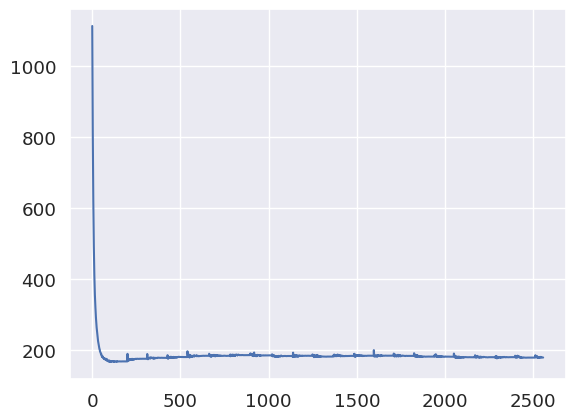

In [13]:
plt.plot(return_dict['eval_losses'])

#### Save Transformer

In [17]:
# optional: save trained model
import datetime
import os
import pickle

timestamp = '-'.join(str(datetime.datetime.now()).split(' '))

data = {'metadata':{'timestamp': timestamp,
                    'save_path': f'./data/biological/trained_models/'},
        'params':{'seed':seed,
                    'sigma': 0.1,
                    'batch_size': batch_size,
                    'tsteps': 15,
                    'input_dim': input_dim,
                    'd_model': d_model,
                    'num_heads': num_heads,
                    'hidden_dim': hidden_dim,
                    'output_dim': output_dim,
                    'n_layers': n_layers,
                    'num_epochs': num_epochs},
        'train_data': return_dict}


torch.save(return_dict['best_eval_params'], save_path / f'EB095-stim-nLS-transformer-param-{d_model}-{num_heads}-{hidden_dim}-{n_layers}-trained-20.pth')
with open(save_path / f'EB095-stim-nLS-transformer-param-metadata-{d_model}-{num_heads}-{hidden_dim}-{n_layers}-trained-20.pkl', 'wb') as f:
    pickle.dump(data, f)
print(f'Saved model parameters and training stats to ./save/trained_models/EB095-stim-nLS-transformer-param-metadata-{d_model}-{num_heads}-{hidden_dim}-{n_layers}-trained-20.pkl')

Saved model parameters and training stats to ./save/trained_models/EB095-stim-nLS-transformer-param-metadata-812-14-971-2-trained-20.pkl


In [19]:
with open(save_path / f'EB095-stim-nLS-transformer-param-metadata-{d_model}-{num_heads}-{hidden_dim}-{n_layers}-trained-20.pkl', 'rb') as f:
    data = pickle.load(f)
DNN_nLS.load_state_dict(torch.load(save_path / f'EB095-stim-nLS-transformer-param-{d_model}-{num_heads}-{hidden_dim}-{n_layers}-trained-20.pth'))

with torch.no_grad():
    Y_hat_nLS = DNN_nLS(X_test.to(device).permute(1,0,2)).permute(1,0,2).cpu()
    nLS_test_pred_loss = nn.MSELoss(reduction='none')(Y_hat_nLS, Y_test[...,nLS_neuron_idx])
    print('Overall Transformer Loss:', nLS_test_pred_loss.sum()/np.prod(nLS_test_pred_loss.shape))
    print('Transformer prediction for forward stim MSE loss: ', nLS_test_pred_loss[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim)
    print('Transformer prediction for backward stim MSE loss: ', nLS_test_pred_loss[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim)
    print('Transformer prediction for random stim MSE loss: ', nLS_test_pred_loss[random_mse_idx].sum() / len(random_mse_idx)/output_dim)
    print('Transformer prediction for non-stim stim MSE loss: ', nLS_test_pred_loss[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim)

Overall Transformer Loss: tensor(168.8808)
Transformer prediction for forward stim MSE loss:  tensor(172.3306)
Transformer prediction for backward stim MSE loss:  tensor(175.9053)
Transformer prediction for random stim MSE loss:  tensor(181.0084)
Transformer prediction for non-stim stim MSE loss:  tensor(157.6054)


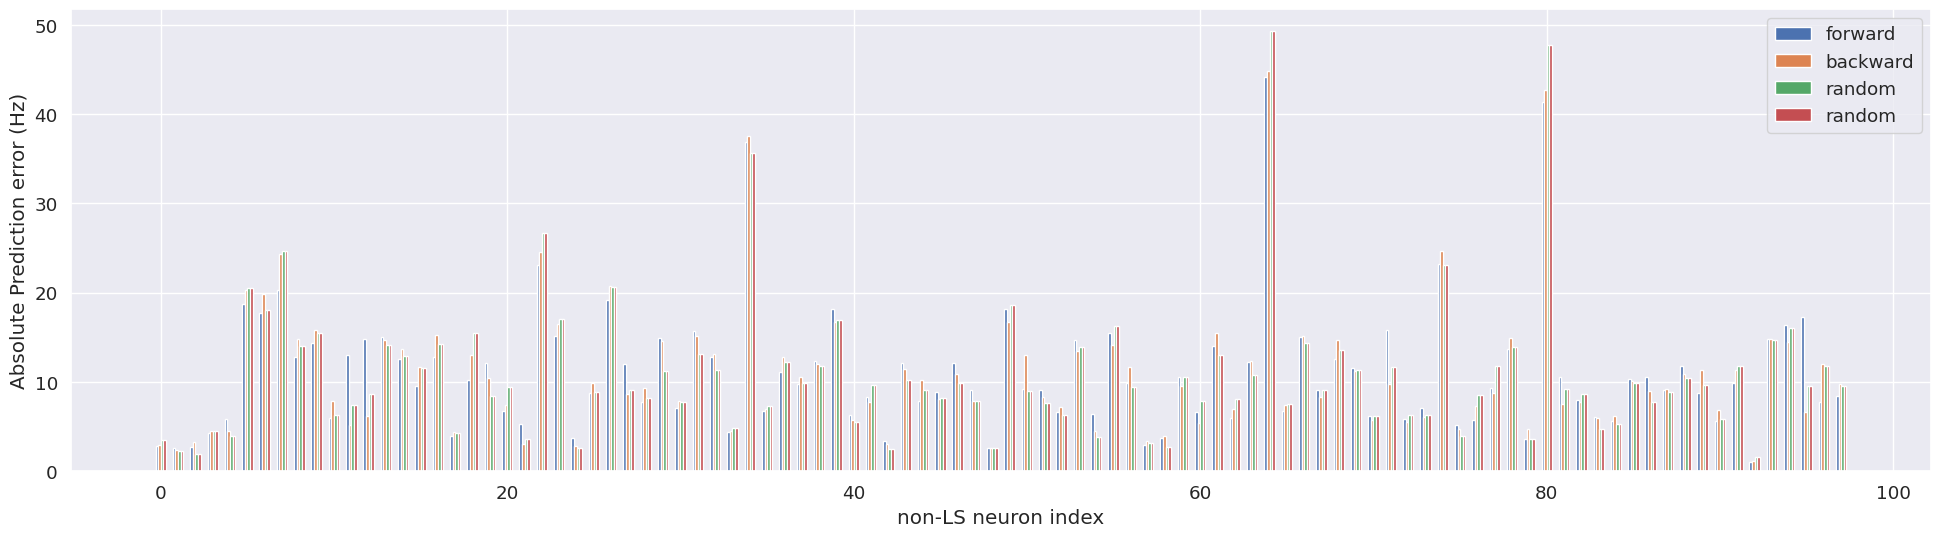

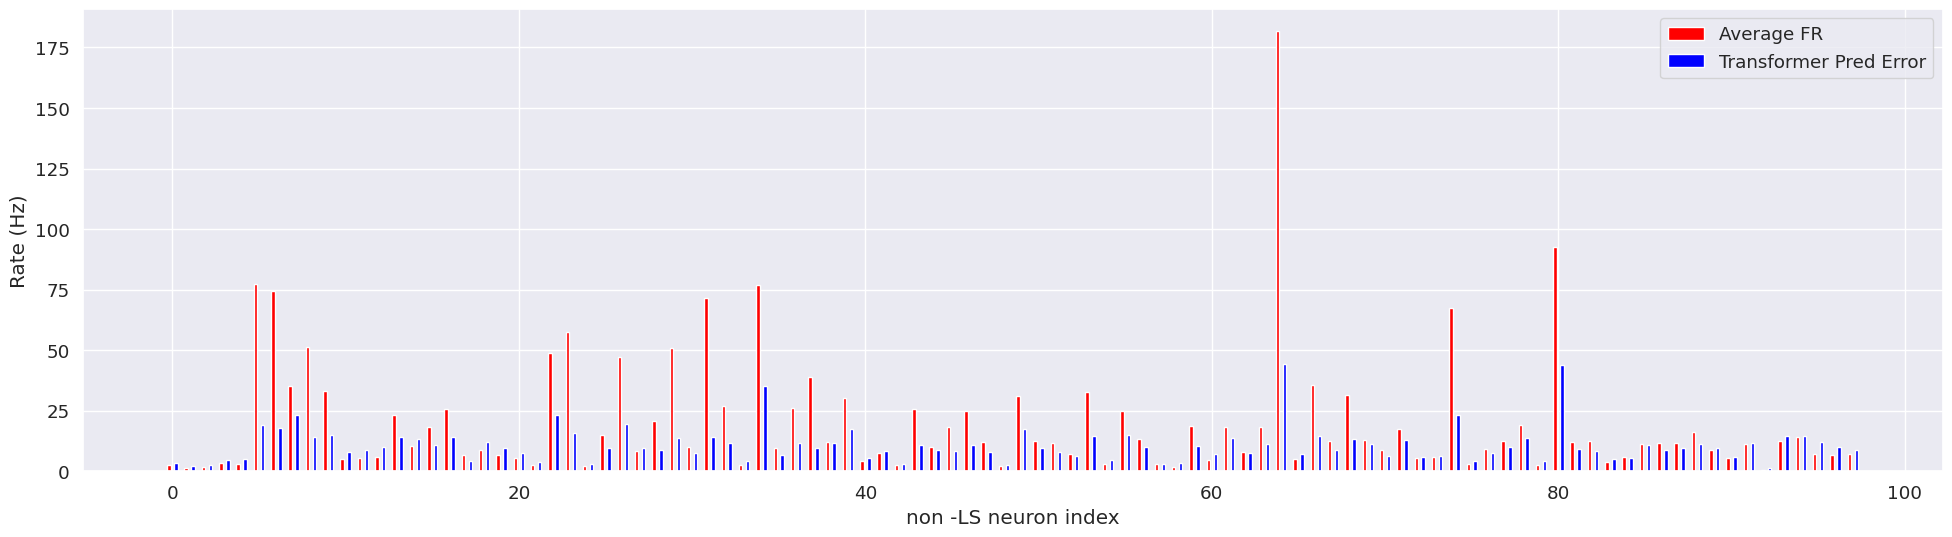

In [20]:
plt.figure(figsize=(24,6))
plt.bar(np.arange(output_dim) - 0.225, torch.sqrt(nLS_test_pred_loss[forward_mse_idx, 0].sum(0)/len(forward_mse_idx)), width=0.15, label='forward')
plt.bar(np.arange(output_dim) - 0.075, torch.sqrt(nLS_test_pred_loss[backward_mse_idx, 0].sum(0)/len(backward_mse_idx)), width=0.15, label='backward')
plt.bar(np.arange(output_dim) + 0.075, torch.sqrt(nLS_test_pred_loss[random_mse_idx, 0].sum(0)/len(random_mse_idx)), width=0.15, label='random')
plt.bar(np.arange(output_dim) + 0.225, torch.sqrt(nLS_test_pred_loss[random_mse_idx, 0].sum(0)/len(random_mse_idx)), width=0.15, label='random')
plt.xlabel('non-LS neuron index')
plt.ylabel('Absolute Prediction error (Hz)')
plt.legend()
plt.show()

plt.figure(figsize=(24,6))
plt.bar(np.arange(output_dim) - 0.2, spks_stim_rates.mean(0)[mask2], color='red', width=0.2, label='Average FR')
plt.bar(np.arange(output_dim) + 0.2, torch.sqrt(nLS_test_pred_loss.sum(0)[0]/nLS_test_pred_loss.shape[0]), color='blue', width=0.2, label='Transformer Pred Error')
try:
    Y_test_nLS_np
    plt.bar(np.arange(output_dim), np.sqrt(np.power(Y_test_nLS_np - Y_test_nLS_np.mean(0), 2).sum(0) / Y_test_nLS_np.shape[0]), width=0.2, label='Pred Mean')
except: pass

plt.xlabel('non -LS neuron index')
plt.ylabel('Rate (Hz)')
plt.legend()
plt.show()

#### Train GLM

In [46]:
# fit GLM with identity link function
X_train_np = X_train[train_idx, ...].cpu().numpy().reshape(X_train[train_idx, ...].shape[0],-1)
Y_train_nLS_np = Y_train_nLS.cpu().numpy().reshape(Y_train_nLS.shape[0],-1) + 1e-6 # numerical stability

X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
Y_test_nLS_np = Y_test_nLS.cpu().numpy().reshape(Y_test_nLS.shape[0],-1) + 1e-6 # numerical stability

output_dim = Y_test_nLS.shape[-1]

from tqdm import tqdm
from sklearn.linear_model import TweedieRegressor

# pred for each neuron
glm_nLS_losses = np.zeros_like(Y_test_nLS_np)
output_dim = Y_test_nLS_np.shape[1]

for i in tqdm(range(output_dim)):
    glm_nLS_reg = TweedieRegressor(power=0, alpha=1, link='identity')
    glm_nLS_reg.fit(X_train_np, Y_train_nLS_np[:,i])
    
    glm_nLS_losses[:,i] += np.power(Y_test_nLS_np[:,i] - glm_nLS_reg.predict(X_test_np), 2)

  0%|          | 0/98 [00:00<?, ?it/s]

100%|██████████| 98/98 [10:55<00:00,  6.69s/it]


#### Train RNN

In [25]:
run_bayes_opt = False
from bayes_opt import BayesianOptimization
from models import RecurrentDNN
from train import train_rnn
from utils import count_parameters

nLS_rnn_param_counts = []

import gc
def black_box_function(hidden_dim, n_rec_layers, n_input_layers, n_output_layers, seed=seed):
    gc.collect()
    torch.cuda.empty_cache()
    
    seed = 123
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    hidden_dim = int(hidden_dim)
    n_rec_layers = int(n_rec_layers)
    n_input_layers = int(n_input_layers)
    n_output_layers = int(n_output_layers)
    
    rnn = RecurrentDNN(input_dim=input_dim,
                hidden_dim=hidden_dim,
                n_rec_layers=n_rec_layers, 
                output_dim=output_dim, 
                n_input_layers=1,
                n_output_layers=1,
                bidirectional=False,
                _type='lstm',
                pos_output=True,
                output_step=1,
                batch_first=True).to(device)
    
    optimiser = torch.optim.Adam(rnn.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.MSELoss()
    
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=10, threshold=0.01)

    return_dict = train_rnn(
        model=rnn, 
        train_loader=train_dataloader_nLS, 
        test_loader=test_dataloader_nLS, 
        optimiser = optimiser, 
        criterion = criterion, 
        num_epochs = 500, 
        verbose=False, 
        force_stop=False, 
        scheduler=scheduler)

    nLS_rnn_param_counts.append([min(return_dict['eval_losses']), count_parameters(rnn), n_rec_layers, hidden_dim])
    valid_loss = -min(return_dict['eval_losses'])   
    del rnn, return_dict
    gc.collect()
    torch.cuda.empty_cache()
    return valid_loss

def run_bayes_opt(pbounds, init_points=50, n_iter=50):
    optimizer = BayesianOptimization(f=black_box_function, pbounds=pbounds, random_state=1)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

if run_bayes_opt:
    run_bayes_opt(pbounds = {'hidden_dim':(10, 1200), 'n_rec_layers':(1, 3), 'n_input_layers':(0, 3), 'n_output_layers':(0, 3)}, init_points=50, n_iter=50)
    np.save(f'./data/trained_models/EB095-stim-nLS-rnn-param_counts.npy', np.array(nLS_rnn_param_counts))

|   iter    |  target   | hidden... | n_inpu... | n_outp... | n_rec_... |
-------------------------------------------------------------------------


 44%|████▍     | 219/500 [01:27<01:52,  2.49it/s]


| 1         | -244.6    | 506.3     | 2.161     | 0.0003431 | 1.605     |


 66%|██████▌   | 329/500 [00:58<00:30,  5.61it/s]


| 2         | -251.6    | 184.6     | 0.277     | 0.5588    | 1.691     |


 45%|████▌     | 226/500 [02:15<02:44,  1.66it/s]


| 3         | -258.1    | 482.2     | 1.616     | 1.258     | 2.37      |


 56%|█████▋    | 282/500 [01:16<00:59,  3.67it/s]


| 4         | -249.1    | 253.3     | 2.634     | 0.08216   | 2.341     |


 44%|████▍     | 219/500 [01:28<01:53,  2.47it/s]


| 5         | -244.6    | 506.6     | 1.676     | 0.4212    | 1.396     |


 34%|███▎      | 168/500 [05:28<10:48,  1.95s/it]


| 6         | -244.7    | 962.9     | 2.905     | 0.9403    | 2.385     |


 35%|███▍      | 173/500 [03:32<06:40,  1.23s/it]


| 7         | -240.6    | 1.053e+03 | 2.684     | 0.2551    | 1.078     |


 63%|██████▎   | 315/500 [00:57<00:33,  5.47it/s]


| 8         | -249.1    | 212.1     | 2.634     | 0.295     | 1.842     |


 32%|███▏      | 158/500 [03:44<08:06,  1.42s/it]


| 9         | -243.9    | 1.15e+03  | 1.599     | 2.076     | 1.631     |


 27%|██▋       | 135/500 [03:14<08:47,  1.44s/it]


KeyboardInterrupt: 

In [47]:
# | 40        | -185.3    | 753.3     | 3.904     |
hidden_dim = 753
n_output_layers = 3
import copy
from train import train_rnn, eval_rnn
from models import RecurrentDNN


rnn = RecurrentDNN(input_dim=input_dim,
                hidden_dim=hidden_dim,
                n_rec_layers=1, 
                output_dim=output_dim, 
                n_input_layers=0,
                n_output_layers=n_output_layers,
                bidirectional=False,
                _type='lstm',
                pos_output=True,
                output_step=1,
                batch_first=True).to(device)
    
optimiser = torch.optim.Adam(rnn.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.MSELoss()

# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=10, threshold=0.01)

return_dict = train_rnn(
    model=rnn, 
    train_loader=train_dataloader_nLS, 
    test_loader=test_dataloader_nLS, 
    optimiser = optimiser, 
    criterion = criterion, 
    num_epochs = 500, 
    verbose=False, 
    force_stop=False, 
    scheduler=scheduler)

with torch.no_grad():
    _, Y_hat_nLS_rnn = eval_rnn(rnn, test_dataloader_nLS, nn.MSELoss(), True)
    nLS_rnn_loss = np.power(Y_test_nLS[:,0,:] - Y_hat_nLS_rnn.cpu(), 2)

c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 98])) that is different to the input size (torch.Size([500, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 98])) that is different to the input size (torch.Size([1024, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([711, 1, 98])) that is different to the input size (torch.Size([711, 98])). This will 

## Evaluation

In [81]:
def levenshtein_distance(arr1, arr2):
    m = len(arr1)
    n = len(arr2)

    # Create a matrix to store the distances
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    # Initialize the first row and column of the matrix
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j

    # Fill in the rest of the matrix
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if arr1[i - 1] == arr2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(dp[i - 1][j],        # Deletion
                                   dp[i][j - 1],        # Insertion
                                   dp[i - 1][j - 1])    # Substitution

    # The bottom-right cell of the matrix contains the Levenshtein distance
    return dp[m][n]

levs_dist = [levenshtein_distance(arr, [1,2,3,4,5,6]) for arr in stim_ID_resolved]

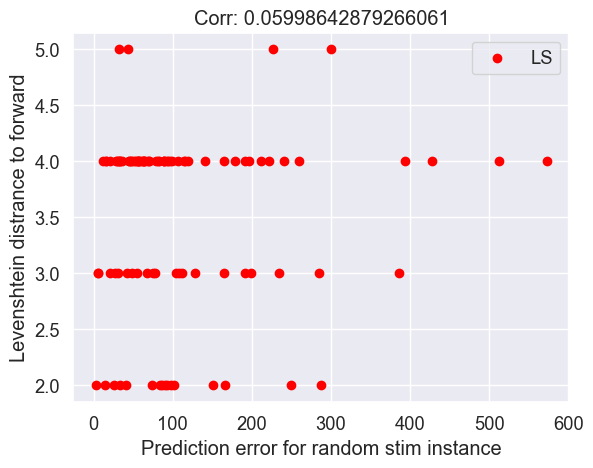

In [82]:
plt.figure()
plt.scatter(LS_test_pred_loss.mean(2)[np.array(random_mse_idx),0], np.array(levs_dist)[np.array(random_mse_idx)], color='red', label='LS')

plt.xlabel('Prediction error for random stim instance')
plt.ylabel('Levenshtein distrance to forward')
plt.title(f'Corr: {np.corrcoef(LS_test_pred_loss.mean(2)[np.array(random_mse_idx),0], np.array(levs_dist)[np.array(random_mse_idx)])[0][1]}')
plt.legend()
plt.show()

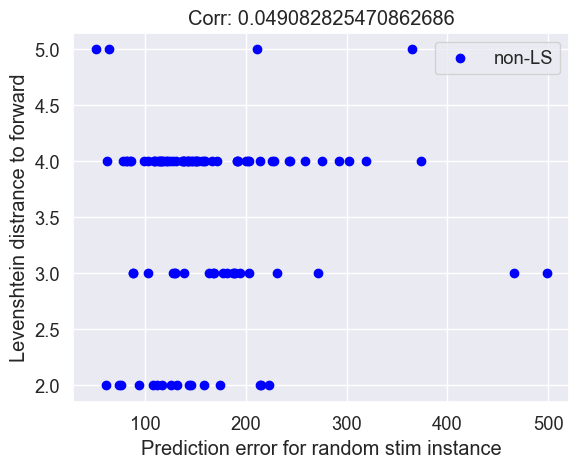

In [50]:
plt.figure()
plt.scatter(nLS_test_pred_loss.mean(2)[np.array(random_mse_idx),0], np.array(levs_dist)[np.array(random_mse_idx)], color='blue', label='non-LS')
plt.xlabel('Prediction error for random stim instance')
plt.ylabel('Levenshtein distrance to forward')
plt.title(f'Corr: {np.corrcoef(nLS_test_pred_loss.mean(2)[np.array(random_mse_idx),0], np.array(levs_dist)[np.array(random_mse_idx)])[0][1]}')
plt.legend()

plt.show()


<BarContainer object of 98 artists>

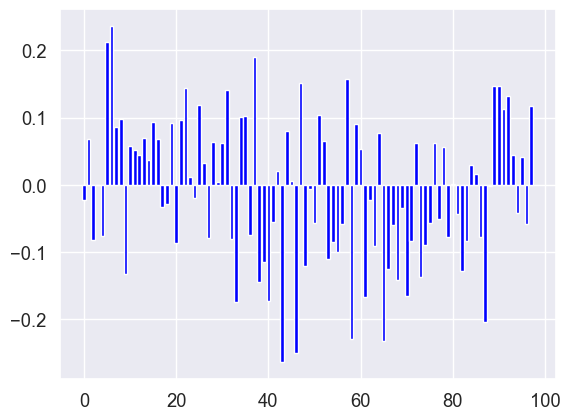

In [52]:
nLS_corrs = [np.corrcoef(nLS_test_pred_loss[np.array(random_mse_idx),0,i], np.array(levs_dist)[np.array(random_mse_idx)])[0][1] for i in range(98)]
    
plt.bar(np.arange(98), nLS_corrs, color='blue')

<BarContainer object of 8 artists>

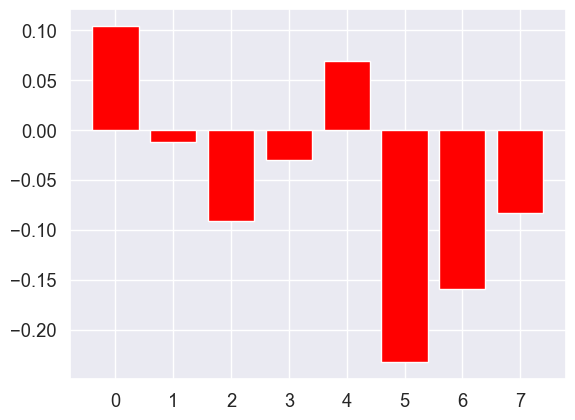

In [83]:
LS_corrs = [np.corrcoef(LS_test_pred_loss[np.array(random_mse_idx),0,i], np.array(levs_dist)[np.array(random_mse_idx)])[0][1] for i in range(8) ]
    
plt.bar(np.arange(8), LS_corrs, color='red')

## Scaling Loss for LS neurons

In [75]:
# TRANSFORMER
# |   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
# | 87        | -99.69    | 262.8     | 478.4     | 5.0       | 1.0       |
# | 65        | -102.9    | 316.6     | 563.4     | 5.0       | 1.0       |
# | 63        | -108.4    | 315.7     | 587.2     | 4.914     | 1.607     |
# | 112       | -111.2    | 139.1     | 926.3     | 4.458     | 9.03      |
from train import train_transformer
from sklearn.linear_model import TweedieRegressor

d_model = 444
num_heads = 6
hidden_dim = 389
n_layers = 4

d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
if d_model % 2 != 0:
    d_model += num_heads

import random

from tqdm import tqdm
from sklearn.linear_model import TweedieRegressor
from loguru import logger

proportion_of_data = [0.05 * i for i in np.arange(1,20,1)]
output_dim = len(LS_neuron_idx)
n_repeats = 25
proportion_of_data_mean_losses_reps = np.zeros((n_repeats, len(proportion_of_data), 10))
np.random.seed(0)
torch.manual_seed(0)

for rep in tqdm(range(n_repeats)):
#     for _, proportion in enumerate(proportion_of_data):
        i = -7
        proportion = 0.65
        rnd_idx = random.sample([i for i in range(len(train_idx))], int(proportion * len(train_idx)))
        batch_size = 8192
        train_dataset = BNN_Dataset(X_train[train_idx, ...][rnd_idx], Y_train_LS[rnd_idx])
        train_dataloader_LS = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
        test_dataset = BNN_Dataset(X_test, Y_test_LS)
        test_dataloader_LS = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=False, shuffle=False)

        _DNN_LS = TransformerOneStep(input_dim,
                d_model=d_model,
                num_heads=num_heads,
                hidden_dim=hidden_dim,
                output_dim=output_dim,
                n_encoder_layers=n_layers,
                device=device, 
                max_len=30,
                dropout=0.2,
                use_mask=True,
                pos_output=True,
                bin_output=False,
                softmax_output=False).to(device)

        optimiser = torch.optim.Adam(_DNN_LS.parameters(), lr=1e-3, weight_decay=1e-4)
        criterion = nn.MSELoss(reduction='none')
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=10, threshold=0.01)
        num_epochs = 500

        _return_dict = train_transformer(
                model=_DNN_LS,
                train_loader=train_dataloader_LS,
                test_loader=test_dataloader_LS,
                optimiser=optimiser,
                criterion=criterion,
                num_epochs=num_epochs,
                verbose=False,
                force_stop=False,
                scheduler=scheduler,
                use_wandb=False,
                stim_type_indices=
                [forward_mse_idx, backward_mse_idx, random_mse_idx, non_stim_mse_idx])

        _DNN_LS.load_state_dict(_return_dict['best_eval_params'])

        with torch.no_grad():
                _Y_hat_LS = _DNN_LS(X_test.to(device).permute(1,0,2)).permute(1,0,2).cpu()
                _LS_test_pred_loss = nn.MSELoss(reduction='none')(_Y_hat_LS, Y_test[...,LS_neuron_idx])

        # fit GLM with identity link function
        X_train_np = X_train[train_idx, ...][rnd_idx].cpu().numpy().reshape(len(rnd_idx),-1)
        Y_train_LS_np = Y_train_LS[rnd_idx].cpu().numpy().reshape(Y_train_LS[rnd_idx].shape[0],-1) + 1e-6 # numerical stability

        X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
        Y_test_LS_np = Y_test_LS.cpu().numpy().reshape(Y_test_LS.shape[0],-1) + 1e-6 # numerical stability


        # pred for each neuron
        _glm_LS_losses = np.zeros(Y_test_LS_np.shape[0])

        for j in tqdm(range(output_dim)):
                _glm_LS_reg = TweedieRegressor(power=0, alpha=1, link='identity')
                _glm_LS_reg.fit(X_train_np, Y_train_LS_np[:,j])
                
                _glm_LS_losses += np.power(Y_test_LS_np[:,j] - _glm_LS_reg.predict(X_test_np), 2)
                
        means = np.array([_LS_test_pred_loss.mean(),
                _LS_test_pred_loss[forward_mse_idx].sum().numpy()/len(forward_mse_idx)/output_dim,
                _LS_test_pred_loss[backward_mse_idx].sum().numpy() / len(backward_mse_idx)/output_dim,
                _LS_test_pred_loss[random_mse_idx].sum().numpy() / len(random_mse_idx)/output_dim,
                _LS_test_pred_loss[non_stim_mse_idx].sum().numpy() / len(non_stim_mse_idx)/output_dim,
                _glm_LS_losses.mean()/output_dim,
                _glm_LS_losses[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim,
                _glm_LS_losses[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim,
                _glm_LS_losses[random_mse_idx].sum() / len(random_mse_idx)/output_dim,
                _glm_LS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim])

        proportion_of_data_mean_losses_reps[rep, i, :] = means

  0%|          | 0/25 [00:00<?, ?it/s]

/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
  4%|▍         | 1/25 [06:27<2:35:11, 387.99s/it]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
  8%|▊         | 2/25 [12:21<2:21:00, 367.84s/it]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/module

In [26]:
proportion_of_data_mean_losses_reps = np.load(save_path / 'EB095-stim-LS-transformer-scaling-loss.npy')

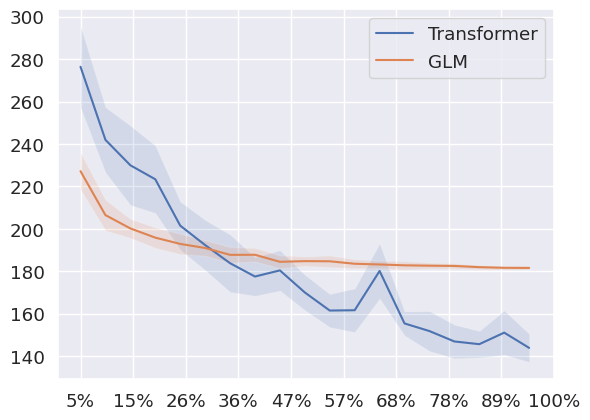

In [27]:
plt.plot(np.mean(proportion_of_data_mean_losses_reps[:, :,4], axis=0), label='Transformer')
plt.fill_between(np.arange(19), np.mean(proportion_of_data_mean_losses_reps[:,:,4], axis=0) - np.std(proportion_of_data_mean_losses_reps[:,:,4], axis=0),
                np.mean(proportion_of_data_mean_losses_reps[:,:,4], axis=0) +np.std(proportion_of_data_mean_losses_reps[:,:,4], axis=0), alpha=0.15)
plt.plot(np.mean(proportion_of_data_mean_losses_reps[:,:,9], axis=0), label='GLM')
plt.fill_between(np.arange(19), np.mean(proportion_of_data_mean_losses_reps[:,:,9], axis=0) - np.std(proportion_of_data_mean_losses_reps[:,:,9], axis=0),
                np.mean(proportion_of_data_mean_losses_reps[:,:,9], axis=0) +np.std(proportion_of_data_mean_losses_reps[:,:,9], axis=0), alpha=0.15)
plt.legend()
plt.xticks(np.linspace(0, 19, 10), [str(int(i*100))+'%' for i in np.linspace(0.05,1,10)])
plt.show()

## For LS neurons, which CA1 neurons are most informative?

#### Simple Lesion test

In [12]:
with torch.no_grad():
    Y_hat_LS = DNN_LS(X_test.to(device).permute(1,0,2)).permute(1,0,2).cpu()
    LS_test_pred_loss = nn.MSELoss(reduction='none')(Y_hat_LS, Y_test[...,LS_neuron_idx])
    base_loss = LS_test_pred_loss[non_stim_mse_idx].mean()
    print('Overall Transformer Loss:', LS_test_pred_loss.mean())
    print('Transformer prediction for forward stim MSE loss: ', LS_test_pred_loss[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim)
    print('Transformer prediction for backward stim MSE loss: ', LS_test_pred_loss[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim)
    print('Transformer prediction for random stim MSE loss: ', LS_test_pred_loss[random_mse_idx].sum() / len(random_mse_idx)/output_dim)
    print('Transformer prediction for non-stim stim MSE loss: ', LS_test_pred_loss[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim)

Overall Transformer Loss: tensor(126.3750)
Transformer prediction for forward stim MSE loss:  tensor(138.8956)
Transformer prediction for backward stim MSE loss:  tensor(132.7131)
Transformer prediction for random stim MSE loss:  tensor(129.0012)
Transformer prediction for non-stim stim MSE loss:  tensor(115.6139)


100%|██████████| 294/294 [00:12<00:00, 22.98it/s]


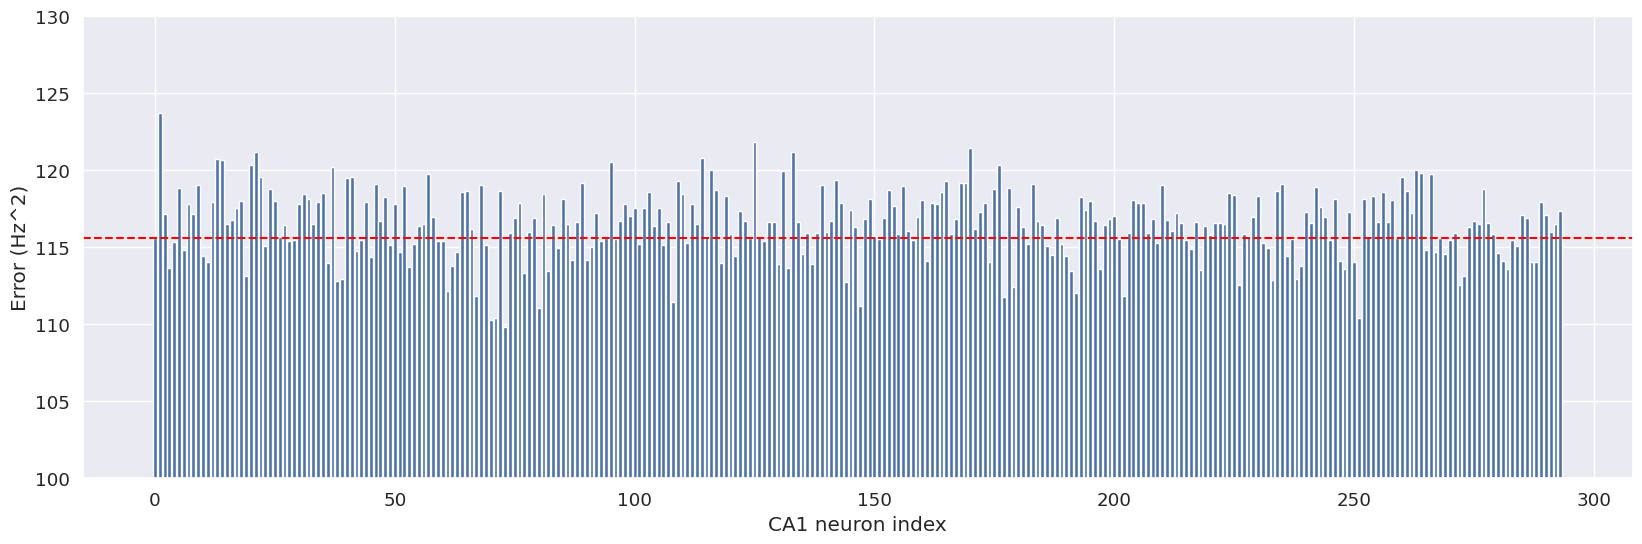

2024-03-18 15:39:30.676 | INFO     | __main__:<module>:20 - Number of neurons whose lesioning yielded higher loss: 192 (65.3%)


In [30]:
# replace with zero
import copy
LS_lesioning_losses = []
for dim in tqdm(range(input_dim)):
    _X_test = copy.deepcopy(X_test)
    _X_test[:,:,dim] = 0
    with torch.no_grad():
        Y_hat_LS = DNN_LS(_X_test.to(device).permute(1,0,2)).permute(1,0,2).cpu()
        LS_test_pred_loss = nn.MSELoss(reduction='none')(Y_hat_LS, Y_test[...,LS_neuron_idx])
        LS_lesioning_losses.append(LS_test_pred_loss[non_stim_mse_idx].mean())

plt.figure(figsize=(20,6))
plt.bar(np.arange(input_dim), LS_lesioning_losses)
plt.axhline(y=base_loss, xmin=0, xmax=input_dim, linestyle='--', c='red')
plt.ylim([100,130])
plt.xlabel('CA1 neuron index')
plt.ylabel('Error (Hz^2)')
plt.show()

logger.info(f'Number of neurons whose lesioning yielded higher loss: {torch.sum(torch.as_tensor(LS_lesioning_losses) > base_loss)} ({str(float(torch.sum(torch.as_tensor(LS_lesioning_losses) > base_loss) / input_dim * 100))[:4]}%)')

100%|██████████| 294/294 [00:12<00:00, 23.36it/s]


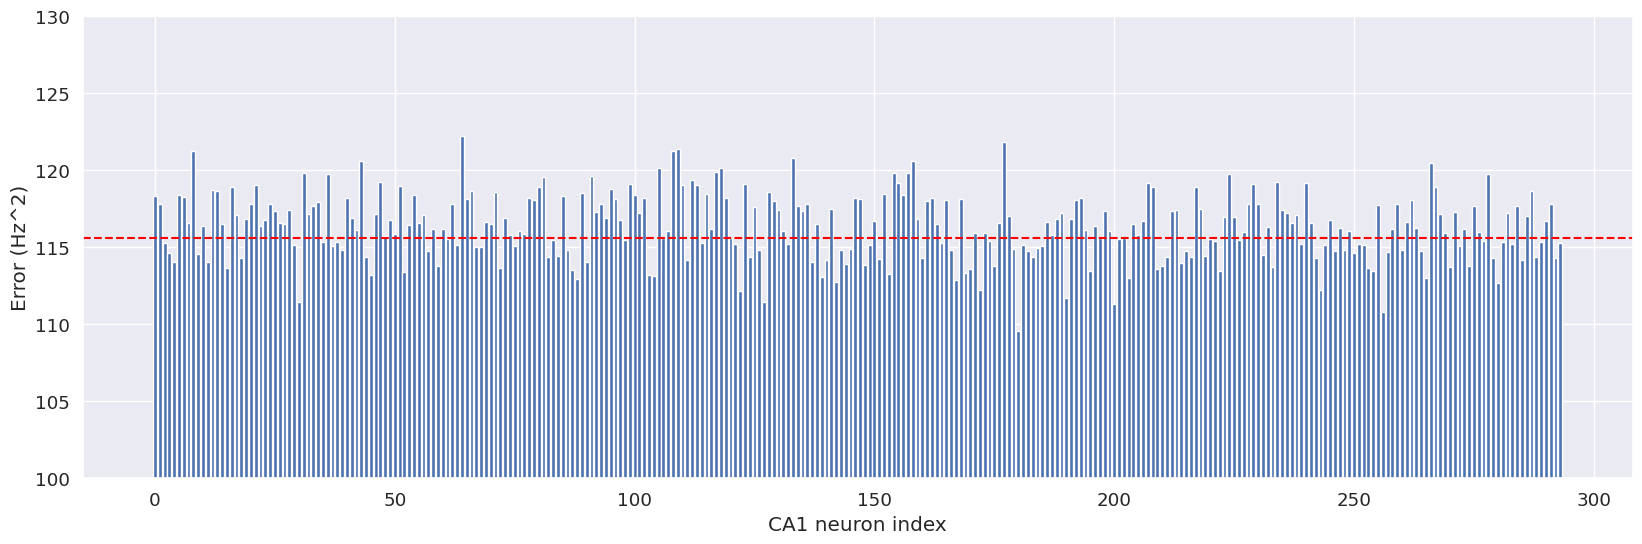

2024-03-18 16:03:20.274 | INFO     | __main__:<module>:20 - Number of neurons whose lesioning yielded higher loss: 175 (59.5%)


In [51]:
# replace with mean FR
import copy
LS_lesioning_losses = []
for dim in tqdm(range(input_dim)):
    _X_test = copy.deepcopy(X_test)
    _X_test[:,:,dim] = torch.mean(X_train[:,:,dim].mean())
    with torch.no_grad():
        Y_hat_LS = DNN_LS(_X_test.to(device).permute(1,0,2)).permute(1,0,2).cpu()
        LS_test_pred_loss = nn.MSELoss(reduction='none')(Y_hat_LS, Y_test[...,LS_neuron_idx])
        LS_lesioning_losses.append(LS_test_pred_loss[non_stim_mse_idx].mean())

plt.figure(figsize=(20,6))
plt.bar(np.arange(input_dim), LS_lesioning_losses)
plt.axhline(y=base_loss, xmin=0, xmax=input_dim, linestyle='--', c='red')
plt.ylim([100,130])
plt.xlabel('CA1 neuron index')
plt.ylabel('Error (Hz^2)')
plt.show()

logger.info(f'Number of neurons whose lesioning yielded higher loss: {torch.sum(torch.as_tensor(LS_lesioning_losses) > base_loss)} ({str(float(torch.sum(torch.as_tensor(LS_lesioning_losses) > base_loss) / input_dim * 100))[:4]}%)')

<BarContainer object of 294 artists>

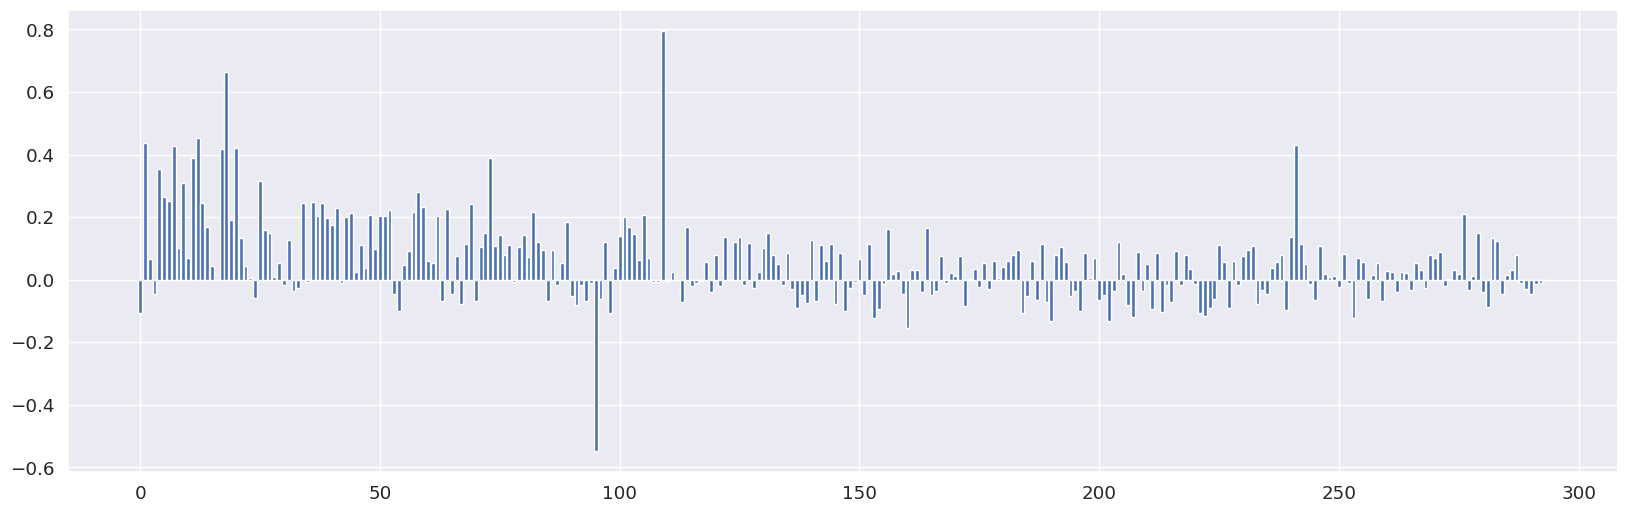

In [42]:
plt.figure(figsize=(20,6))
plt.bar(torch.arange(294), X_train.mean((0,1)))

<BarContainer object of 294 artists>

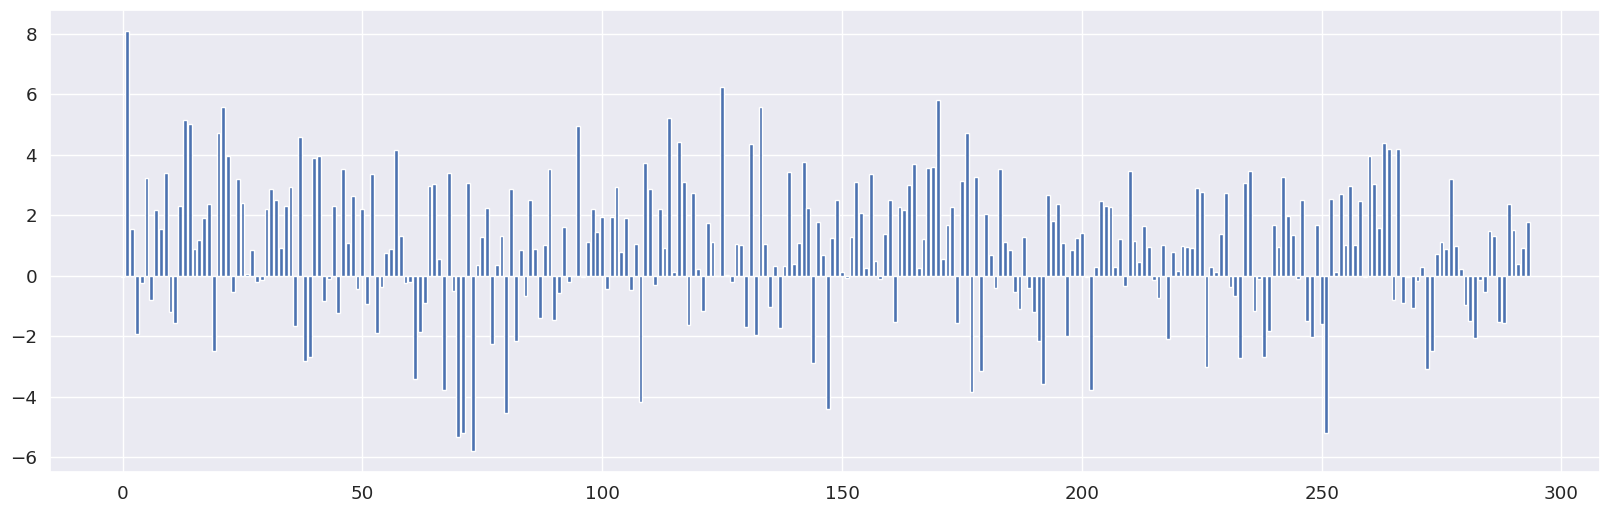

In [44]:
plt.figure(figsize=(20,6))
plt.bar(np.arange(294), torch.stack(LS_lesioning_losses) - base_loss)

In [52]:
torch.corrcoef(torch.vstack(
    [torch.stack(LS_lesioning_losses) - base_loss, X_train.mean((0,1))]
    ))

tensor([[1.0000, 0.0980],
        [0.0980, 1.0000]])

In [53]:
torch.corrcoef(torch.vstack(
    [torch.stack(LS_lesioning_losses) - base_loss, X_train.std((0,1))]
    ))

tensor([[1.0000, 0.1310],
        [0.1310, 1.0000]])

1. insert the mean of that cell
2. insert a number drawn from gaussian with same mean and stid 
3. permute the time sequence ***
ONLY ON ENDOGENOUS DATA - ON THE SCALING LOSS AS WELL

### Mutual Information test

In [218]:
from sklearn.feature_selection import mutual_info_regression

lags = np.arange(tsteps)
mi_scores_by_lag_and_output_dim = np.zeros((tsteps, output_dim, input_dim))
for out in tqdm(range(output_dim)):
    for lag in tqdm(lags):
        input_features = np.array(X_test[:, lag, :])
        output_features = np.array(Y_test_LS[:, 0, out])
        mi_scores_by_lag_and_output_dim[lag, out,:] = mutual_info_regression(input_features, output_features)

100%|██████████| 8/8 [00:59<00:00,  7.43s/it]


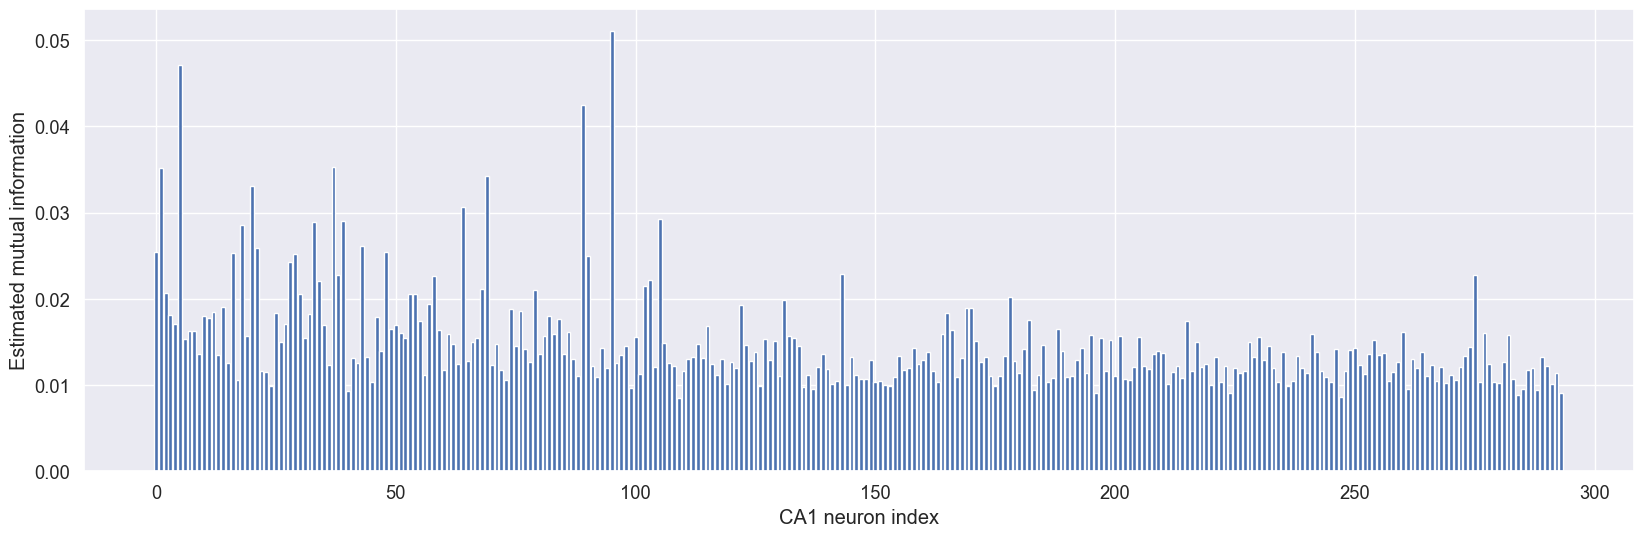

In [236]:
plt.figure(figsize=(20,6))
plt.bar(np.arange(input_dim), mi_scores_by_lag_and_output_dim.mean(axis=(0,1)))
plt.xlabel('CA1 neuron index')
plt.ylabel('Estimated mutual information')
plt.show()

In [255]:
LS_mi_mean_top10 = list(np.argsort(mi_scores_by_lag_and_output_dim.mean(axis=(0,1)))[::-1][:10])
logger.info(f'Top 10 mutual information: {LS_mi_mean_top10}')

2024-03-05 17:11:37.939 | INFO     | __main__:<module>:2 - Top 10 mutual information: [95, 5, 89, 37, 1, 69, 20, 64, 105, 39]


## Attention Weights

In [21]:
def get_attention_hook(attention_weights_dict, layer_name):
    def hook(module, input, output):
        if len(output) == 2:
            attention_weights_dict[layer_name] = output[1].detach()
    return hook

attention_weights_dict = {}

for name, module in DNN_LS.named_modules():
    if isinstance(module, 
                  torch.nn.MultiheadAttention):
        hook = get_attention_hook(attention_weights_dict, name)
        module.register_forward_hook(hook)
        
with torch.no_grad():
    Y_test_nLS_hat = DNN_LS(X_test.permute(1,0,2).to(device)).permute(1,0,2)

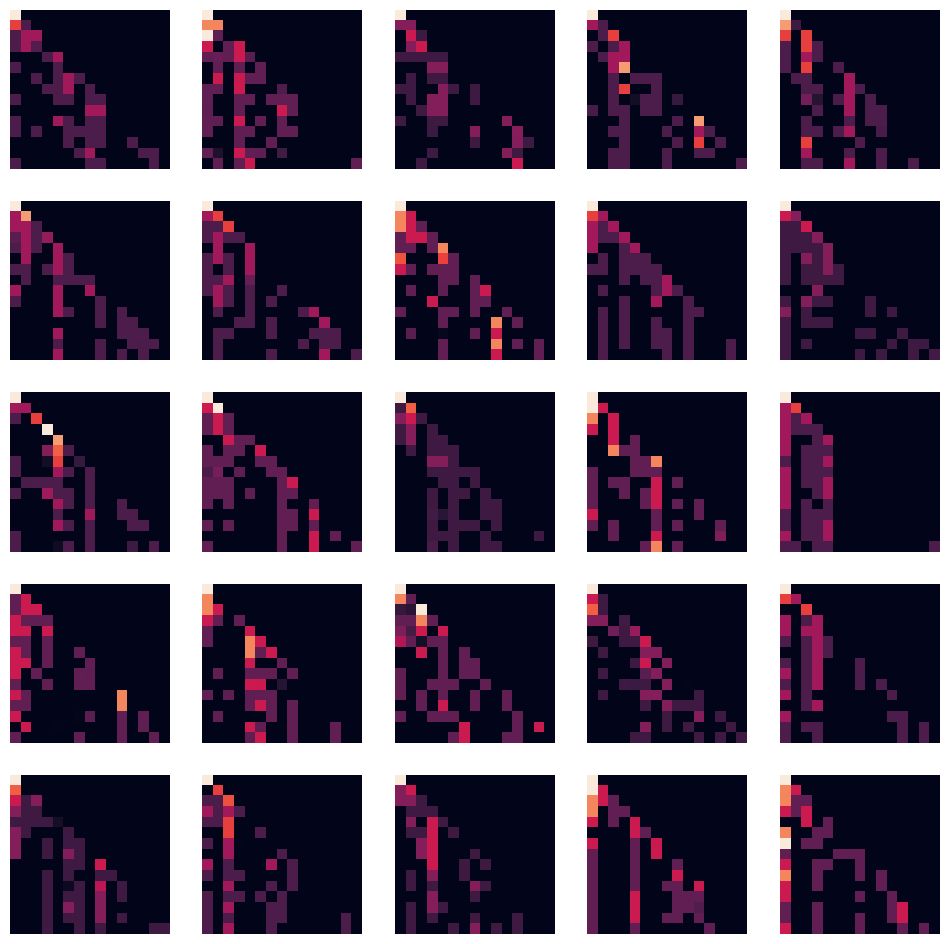

In [45]:
# plot first attention layer
nrows, ncols = 5, 5

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(12,12))
for r in range(nrows):
    if r == 0:
        # show 5 forward pattern
        show_idxs = list(np.random.choice(forward_mse_idx, 5))
    elif r == 1:
        show_idxs = list(np.random.choice(backward_mse_idx, 5))
    elif r == 2:
        show_idxs = list(np.random.choice(random_mse_idx, 5))
    else:
        show_idxs = list(np.random.choice(non_stim_mse_idx, 5))

    for c in range(ncols):
        axs[r,c].matshow(attention_weights_dict['encoder.layers.0.self_attn'][show_idxs[c]].cpu().numpy())
        axs[r,c].axis('off')
        axs[r,c].set_xlabel('s')

# lower triangular due to masking of future positions


In [53]:
list(attention_weights_dict.values())[0].shape

torch.Size([500, 15, 15])